# **Feature Engineering Notebook**

## Objectives

* Engineer features for Classification, Regression and Cluster model

## Inputs

* inputs/datasets/cleaned/TrainSet.csv
* inputs/datasets/cleaned/TestSet.csv

## Outputs

* Generate a list with variables to engineer

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\Andrias\\Desktop\\patient-readmission\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\Andrias\\Desktop\\patient-readmission'

# Load Cleaned Data

Train set

In [5]:
import pandas as pd

train_set_path = "outputs/datasets/cleaned/TrainSetCleaned.csv"
TrainSet = pd.read_csv(train_set_path)
print(TrainSet.shape)
TrainSet.head()

(20000, 16)


age  time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
0  [70-80)                 4                47             0             21   
1  [60-70)                 3                50             1             11   
2  [50-60)                 4                66             1             10   
3  [50-60)                14                63             0             28   
4  [50-60)                 3                60             2             25   

   n_outpatient  n_inpatient  n_emergency           diag_1       diag_2  \
0             0            1            0            Other        Other   
1             0            0            0  Musculoskeletal  Circulatory   
2             0            0            0            Other        Other   
3             0            0            0      Respiratory  Circulatory   
4             3            2            4            Other     Diabetes   

     diag_3 glucose_test A1Ctest  change  diabetes_med  readmitted  
0     Other           no      no       1             1           1  
1  Diabetes           no      no       0             0           0  
2  Diabetes           no    high       0             0           0  
3  Diabetes       normal      no       0             1           1  
4     Other           no      no       1             1           1

Test set

In [6]:
test_set_path = 'outputs/datasets/cleaned/TestSetCleaned.csv'
TestSet = pd.read_csv(test_set_path)
print(TestSet.shape)
TestSet.head()

(5000, 16)


age  time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
0  [70-80)                 1                17             1              5   
1  [60-70)                 1                37             1             12   
2  [80-90)                 4                43             3             15   
3  [60-70)                 3                69             0             13   
4  [80-90)                 5                58             0             11   

   n_outpatient  n_inpatient  n_emergency       diag_1       diag_2  \
0             0            4            2  Respiratory        Other   
1             0            0            0        Other  Circulatory   
2             1            0            0    Digestive  Respiratory   
3             0            5            0        Other        Other   
4             0            1            0        Other        Other   

        diag_3 glucose_test A1Ctest  change  diabetes_med  readmitted  
0        Other       normal      no       0             0           1  
1  Respiratory           no      no       0             1           1  
2     Diabetes           no      no       0             1           1  
3  Respiratory           no      no       0             1           0  
4     Diabetes           no      no       1             1           1

We also going to load the dataset we processed and used for the Correlation study, after applying the LogTransformer, StandardScaler and PCA, for comparison.

In [24]:
processed_set_path = "outputs/datasets/collection/HospitalReadmissionsCorrelation.csv"
df_processed = pd.read_csv(processed_set_path)
print(df_processed.shape)
df_processed.head()

(25000, 12)


time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
0          0.707470         -0.296963     -0.854086      -0.293311   
1         -0.648949         -1.100765      0.006085      -0.645437   
2          0.873880         -0.004648      0.921201       0.301737   
3         -0.073264          0.981894      1.403755       0.225191   
4         -2.129643         -0.363091      1.062368       0.530786   

   n_outpatient  n_inpatient  n_emergency  glucose_test   A1Ctest    change  \
0      0.726936     1.262978     0.450521      2.007733 -0.528104  0.438563   
1     -0.308202     0.319402    -0.334175      0.087033 -0.164047 -0.389870   
2     -0.184175    -1.259272     0.328781      0.379579 -0.848217  0.609829   
3     -0.249035    -0.114229     1.248973      0.927288 -0.948467 -0.004911   
4     -0.141614     0.037219    -0.530839      0.606276 -0.449818 -0.751791   

   diabetes_med  readmitted  
0     -1.198721           0  
1     -1.019523           0  
2      0.383970           1  
3      0.447836           1  
4     -0.943818           0

---

# Feature engineering

### Custom Function

In [64]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder

sns.set(style="darkgrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None, y=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'categorical_encoding', 'outlier_winsorizer', 'discretisation']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column, y=y)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'categorical_encoding':
        list_column_transformers = ["ordinal_encoder", "one_hot_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr', 'gaussian']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column, y=None):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'categorical_encoding':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'categorical_encoding':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []

    # OrdinalEncoder
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")
    except Exception as e:
        print(f"OrdinalEncoder failed for {column}: {e}")
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer with IQR
    try:
        if df_feat_eng[column].nunique() > 1:  # Check for variation in the original column
            disc = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=[column])
            df_feat_eng[f"{column}_iqr"] = disc.fit_transform(df_feat_eng[[column]])
            list_methods_worked.append(f"{column}_iqr")
        else:
            print(f"Skipping Winsorizer (IQR) for {column} due to low variation.")
    except Exception as e:
        print(f"Winsorizer (IQR) failed for {column}: {e}")
        if f"{column}_iqr" in df_feat_eng.columns:
            df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    # Winsorizer with Gaussian method
    try:
        disc = Winsorizer(capping_method='gaussian', tail='both', fold=3, variables=[column])
        df_feat_eng[f"{column}_gaussian"] = disc.fit_transform(df_feat_eng[[column]])
        list_methods_worked.append(f"{column}_gaussian")
    except Exception as e:
        print(f"Winsorizer (Gaussian) failed for {column}: {e}")
        if f"{column}_gaussian" in df_feat_eng.columns:
            df_feat_eng.drop([f"{column}_gaussian"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception as e:
        print(f"LogTransformer failed for {column}: {e}")
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception as e:
        print(f"LogTransformer failed for {column}: {e}")
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception as e:
        print(f"ReciprocalTransformer failed for {column}: {e}")
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception as e:
        print(f"PowerTransformer failed for {column}: {e}")
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception as e:
        print(f"BoxCoxTransformer failed for {column}: {e}")
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception as e:
        print(f"YeoJohnsonTransformer failed for {column}: {e}")
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

## Categorical encoding

In [8]:
categorical_variables = TrainSet.select_dtypes(include='object').columns
categorical_variables

Index(['age', 'diag_1', 'diag_2', 'diag_3', 'glucose_test', 'A1Ctest'], dtype='object')

In [9]:
df_cat_engineering =TrainSet[categorical_variables].copy()
df_cat_engineering.head()

age           diag_1       diag_2    diag_3 glucose_test A1Ctest
0  [70-80)            Other        Other     Other           no      no
1  [60-70)  Musculoskeletal  Circulatory  Diabetes           no      no
2  [50-60)            Other        Other  Diabetes           no    high
3  [50-60)      Respiratory  Circulatory  Diabetes       normal      no
4  [50-60)            Other     Diabetes     Other           no      no

* Variable Analyzed: age
* Applied transformation: ['age_ordinal_encoder'] 



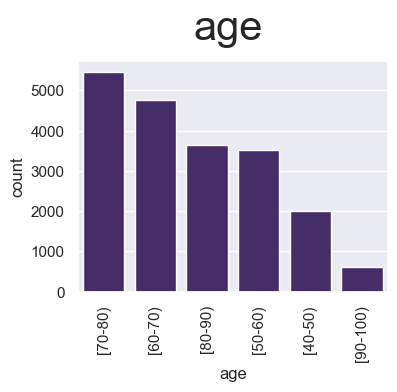

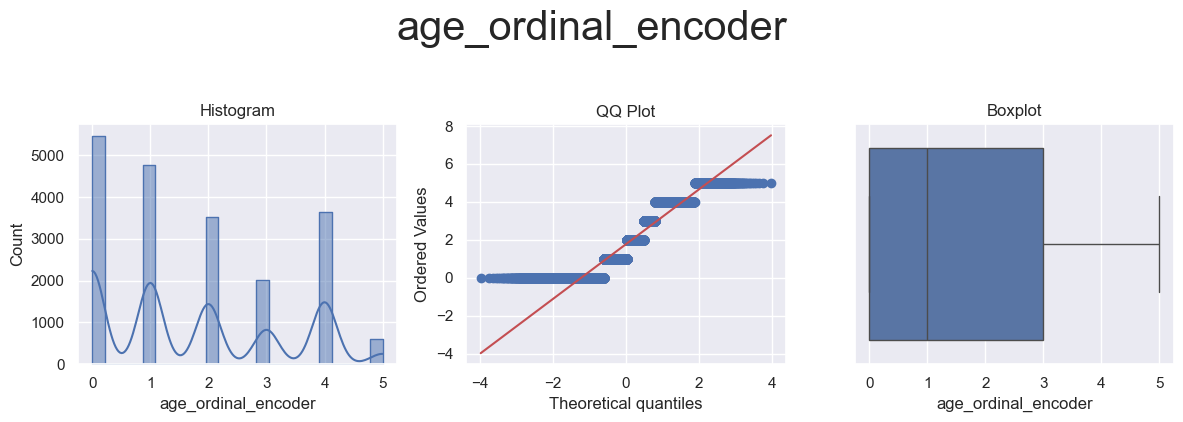



* Variable Analyzed: diag_1
* Applied transformation: ['diag_1_ordinal_encoder'] 



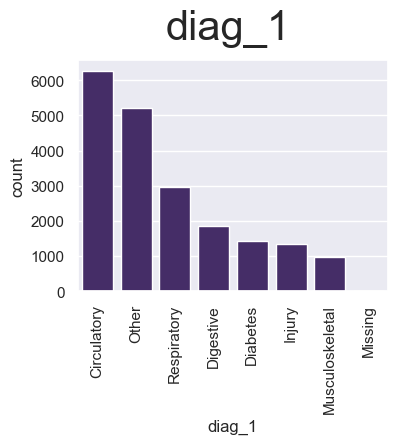

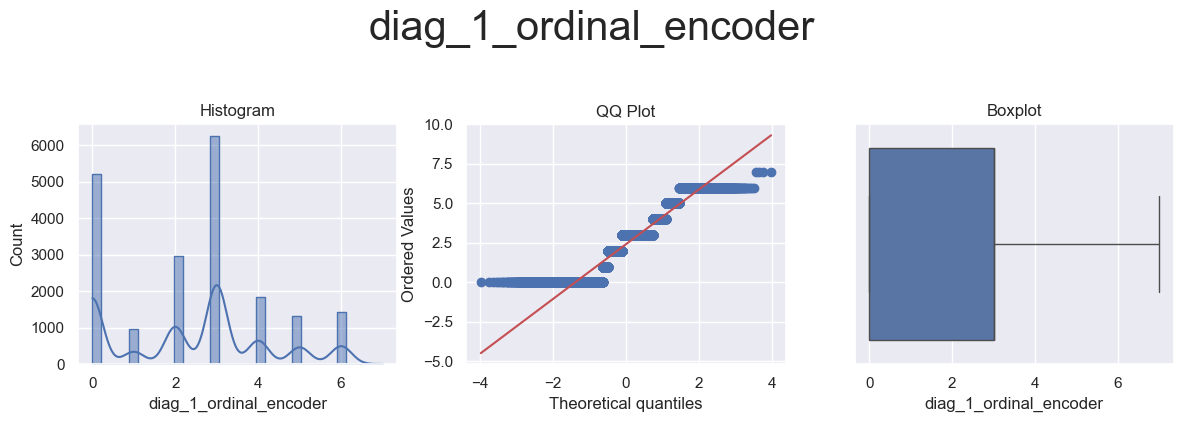



* Variable Analyzed: diag_2
* Applied transformation: ['diag_2_ordinal_encoder'] 



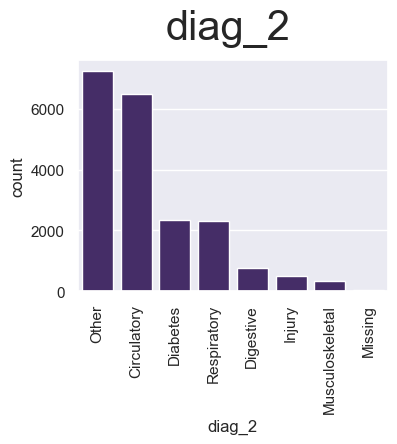

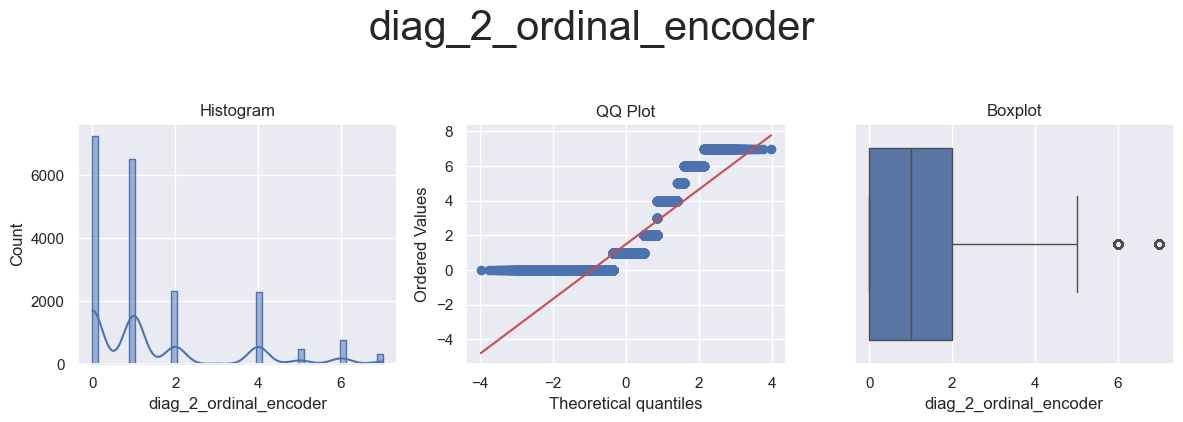



* Variable Analyzed: diag_3
* Applied transformation: ['diag_3_ordinal_encoder'] 



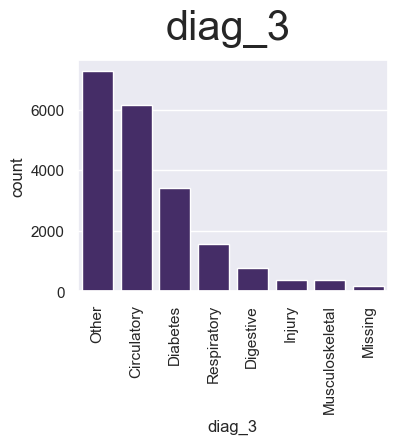

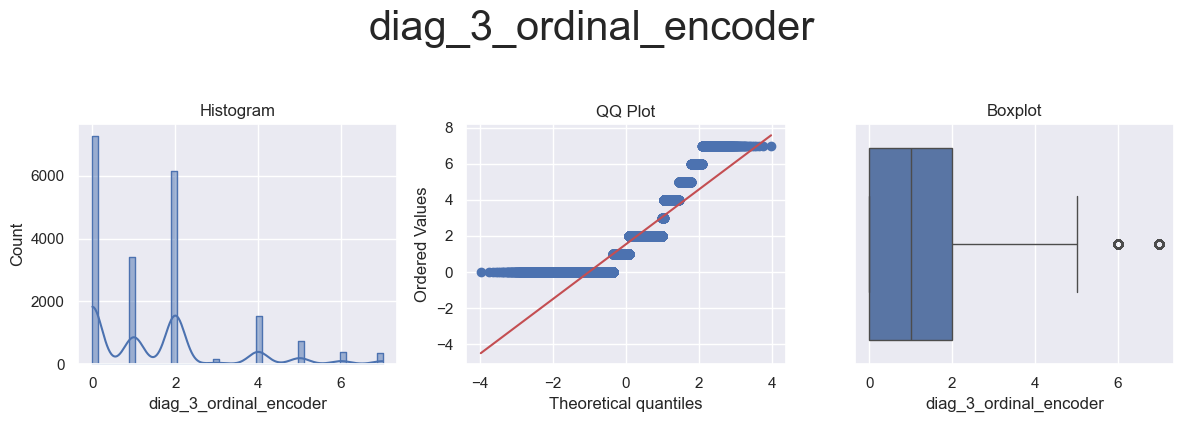



* Variable Analyzed: glucose_test
* Applied transformation: ['glucose_test_ordinal_encoder'] 



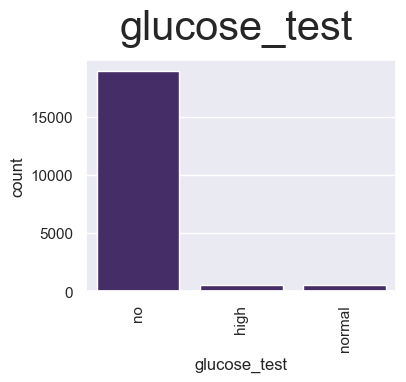

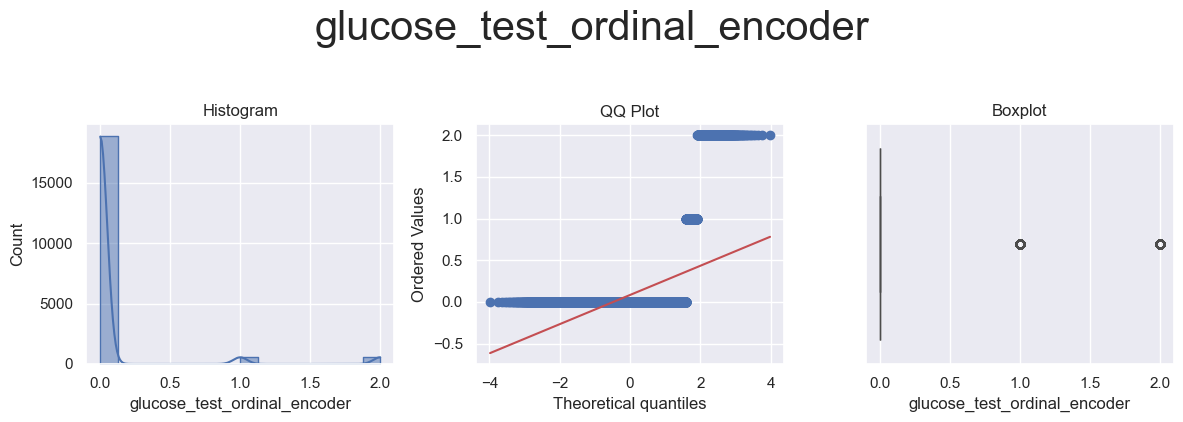



* Variable Analyzed: A1Ctest
* Applied transformation: ['A1Ctest_ordinal_encoder'] 



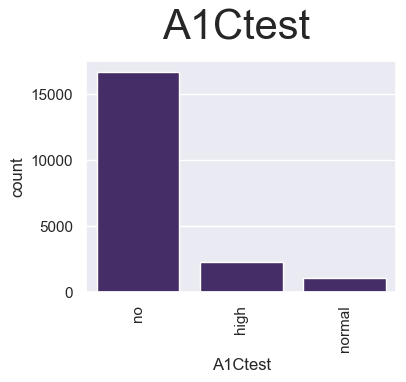

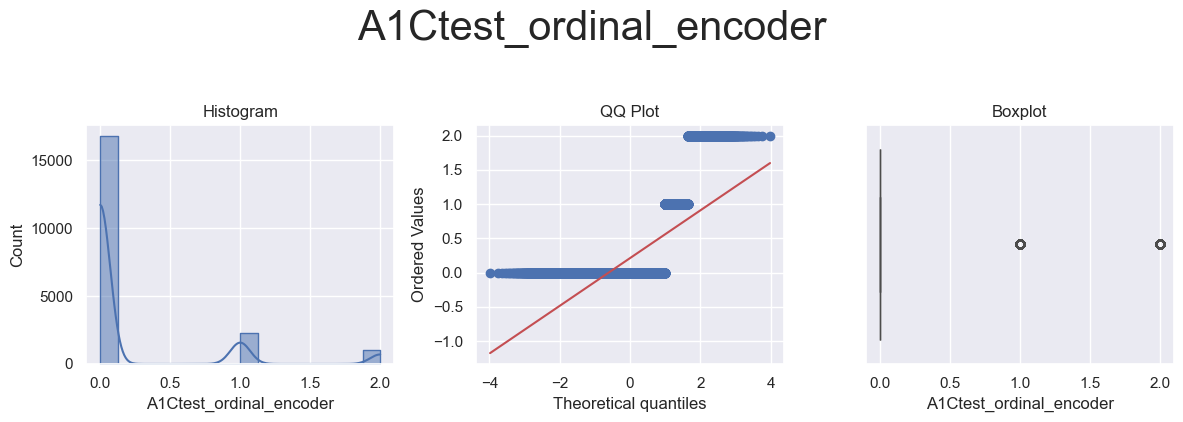

In [10]:
df_cat_engineered = FeatureEngineeringAnalysis(df_cat_engineering, analysis_type='categorical_encoding')

## Numerical Transformation

In [11]:
numerical_variables = TrainSet.select_dtypes(include='number').columns
numerical_variables

Index(['time_in_hospital', 'n_lab_procedures', 'n_procedures', 'n_medications',
       'n_outpatient', 'n_inpatient', 'n_emergency', 'change', 'diabetes_med',
       'readmitted'],
      dtype='object')

In [12]:
df_num_engineering = TrainSet[numerical_variables].copy()
df_num_engineering.drop(['readmitted'],axis=1,inplace=True)
df_num_engineering.head()

time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
0                 4                47             0             21   
1                 3                50             1             11   
2                 4                66             1             10   
3                14                63             0             28   
4                 3                60             2             25   

   n_outpatient  n_inpatient  n_emergency  change  diabetes_med  
0             0            1            0       1             1  
1             0            0            0       0             0  
2             0            0            0       0             0  
3             0            0            0       0             1  
4             3            2            4       1             1

##### Handling Outliers

* Variable Analyzed: time_in_hospital
* Applied transformation: ['time_in_hospital_iqr', 'time_in_hospital_gaussian'] 



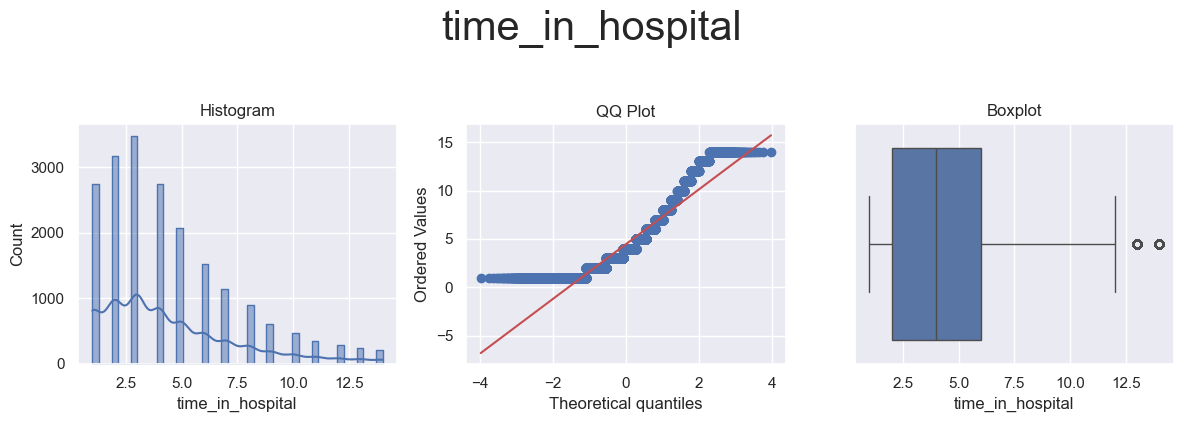

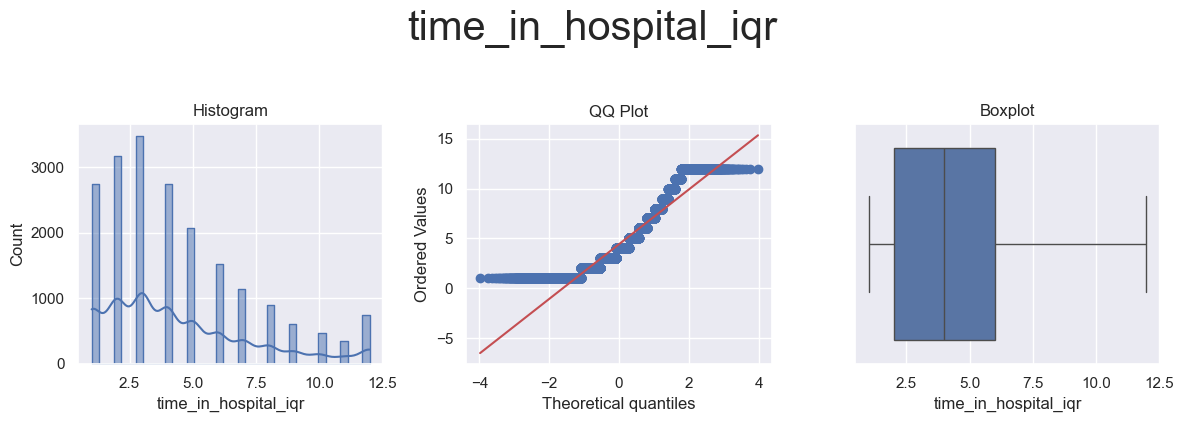

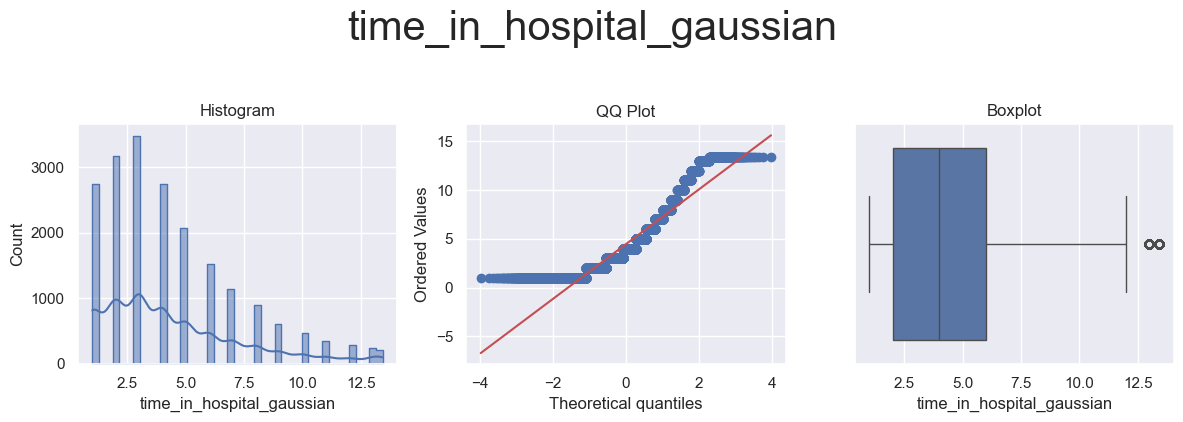



* Variable Analyzed: n_lab_procedures
* Applied transformation: ['n_lab_procedures_iqr', 'n_lab_procedures_gaussian'] 



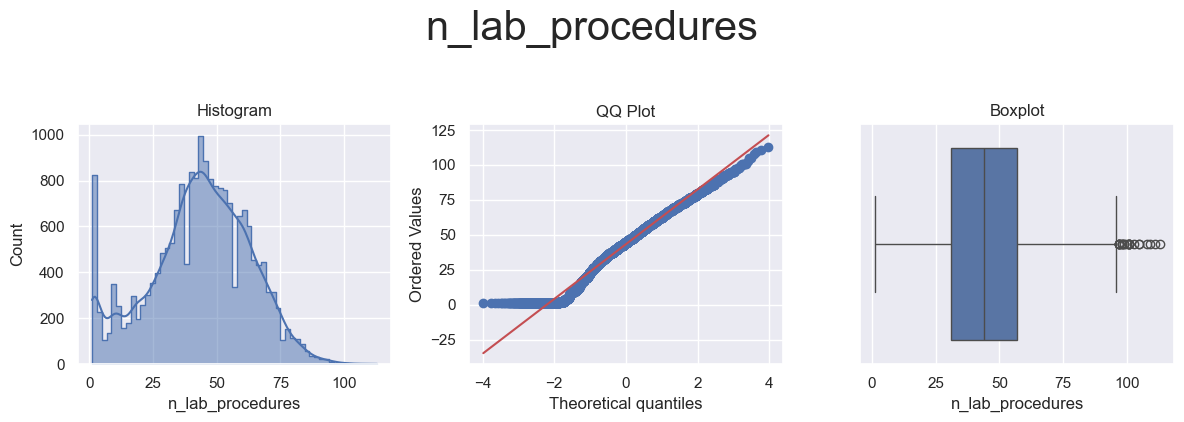

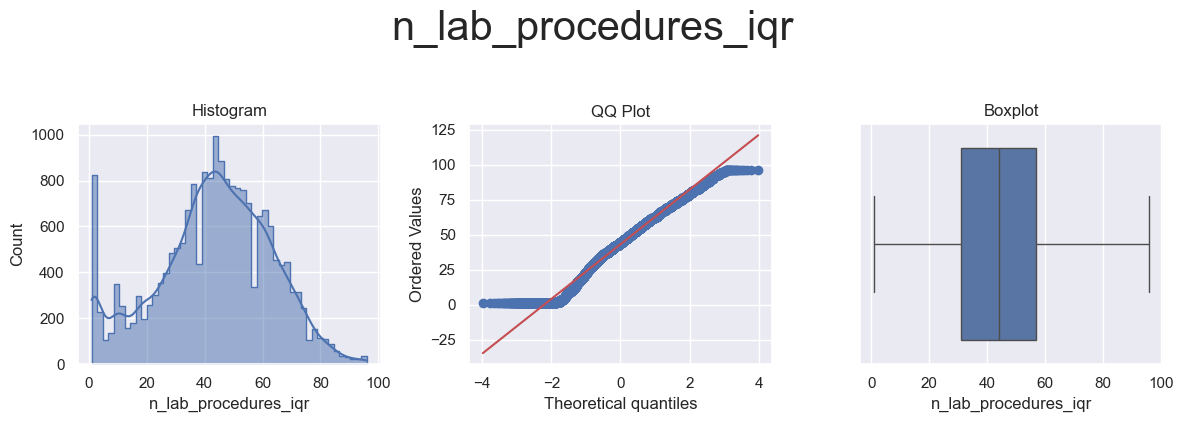

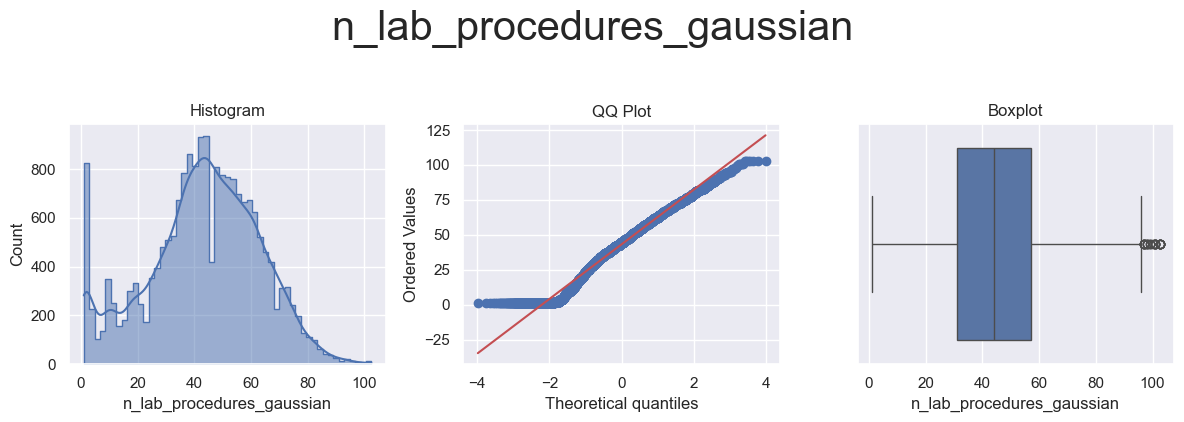



* Variable Analyzed: n_procedures
* Applied transformation: ['n_procedures_iqr', 'n_procedures_gaussian'] 



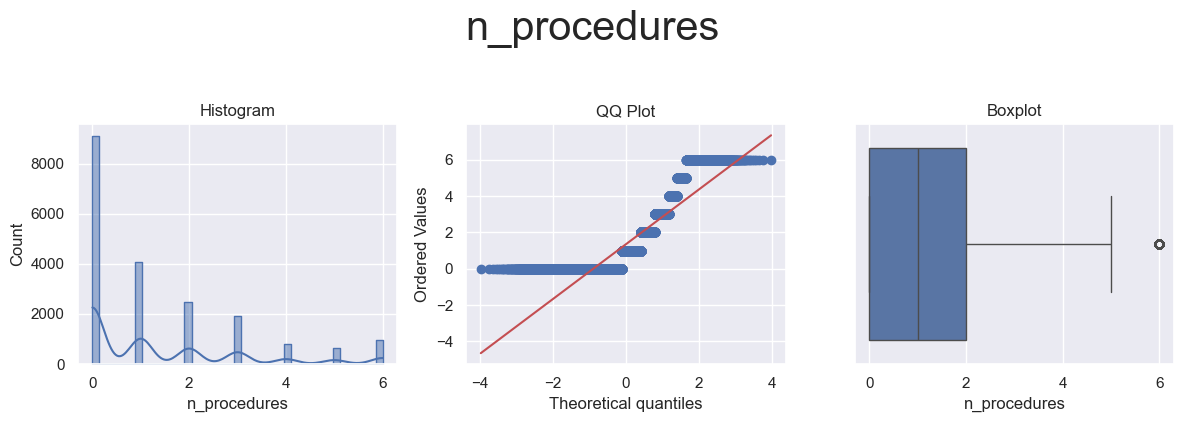

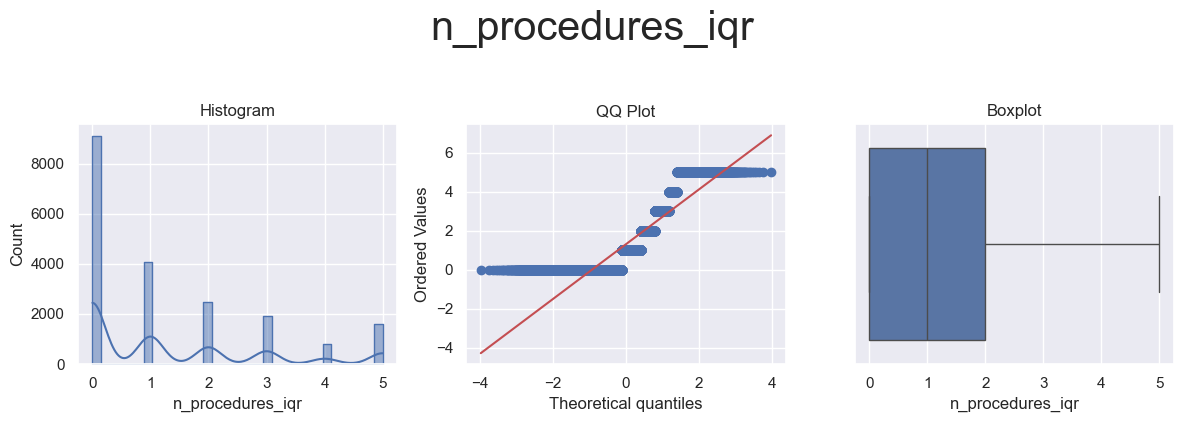

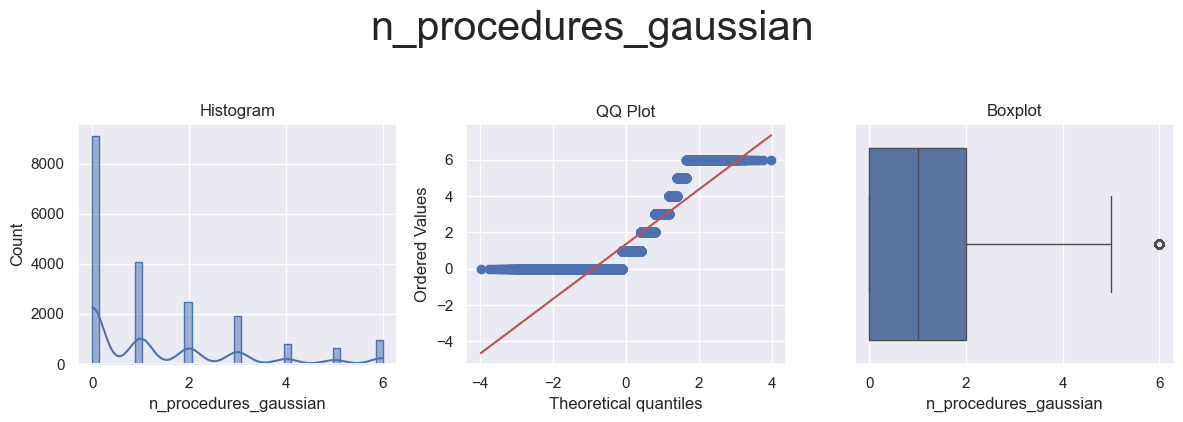



* Variable Analyzed: n_medications
* Applied transformation: ['n_medications_iqr', 'n_medications_gaussian'] 



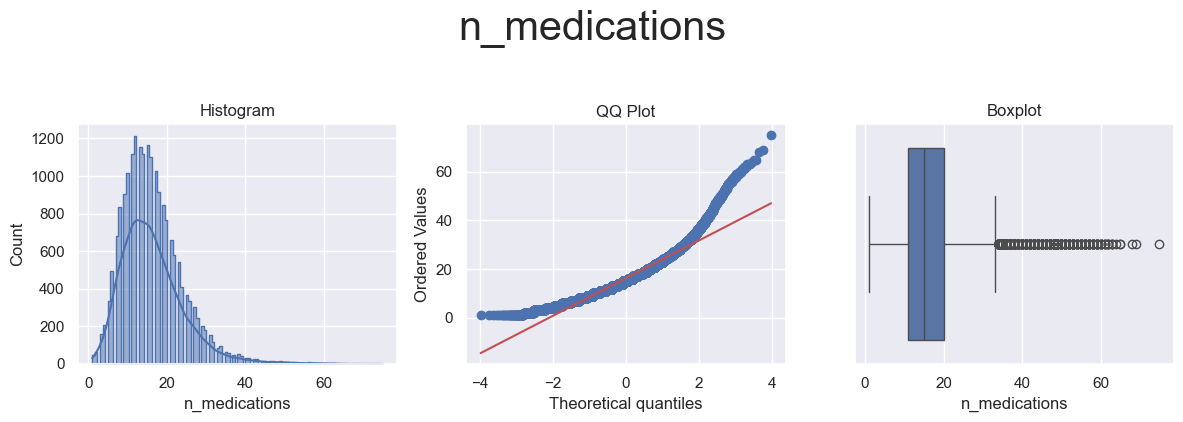

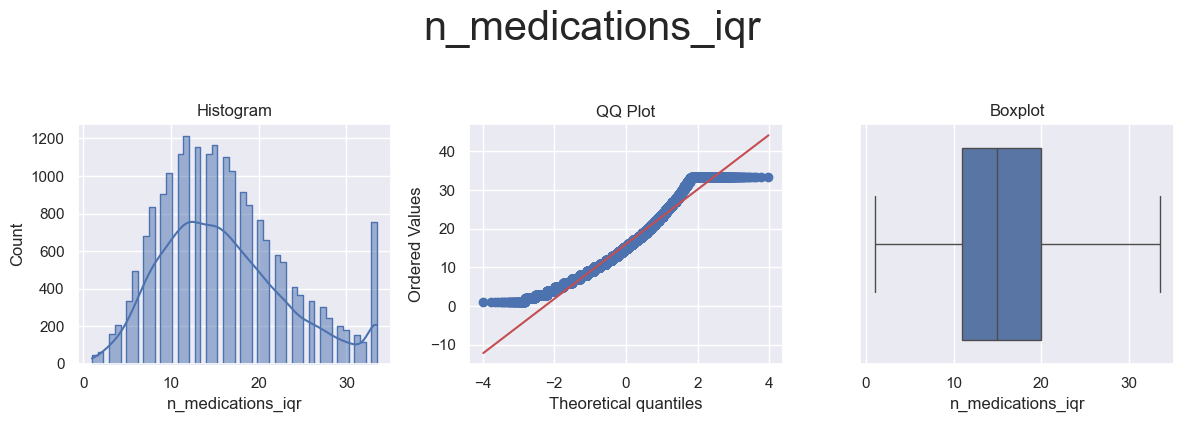

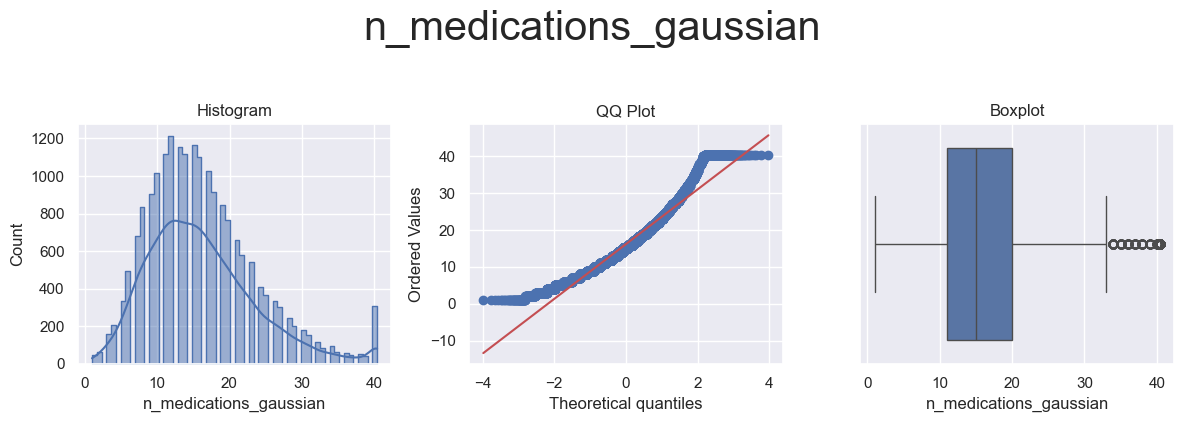



Winsorizer (IQR) failed for n_outpatient: Input columns ['n_outpatient'] have low variation for method 'iqr'. Try other capping methods or drop these columns.
* Variable Analyzed: n_outpatient
* Applied transformation: ['n_outpatient_gaussian'] 



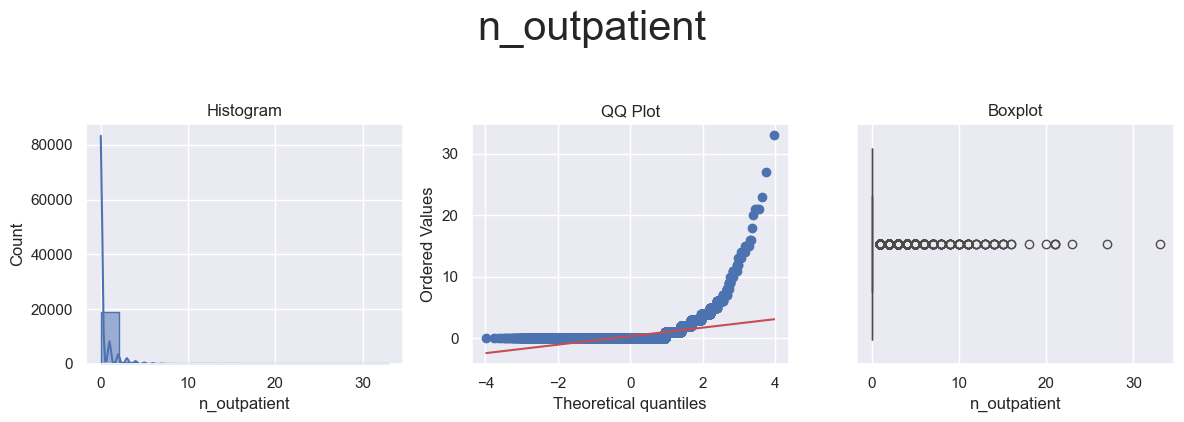

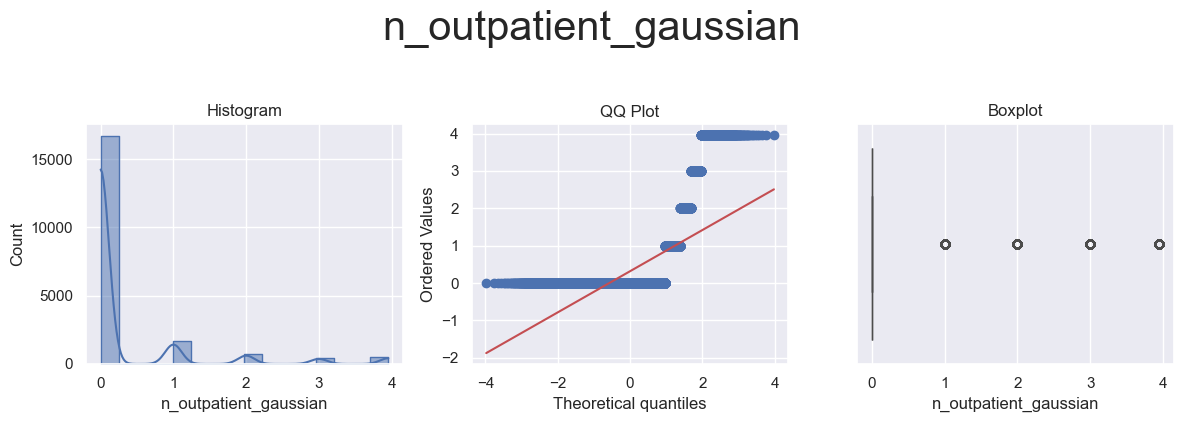



* Variable Analyzed: n_inpatient
* Applied transformation: ['n_inpatient_iqr', 'n_inpatient_gaussian'] 



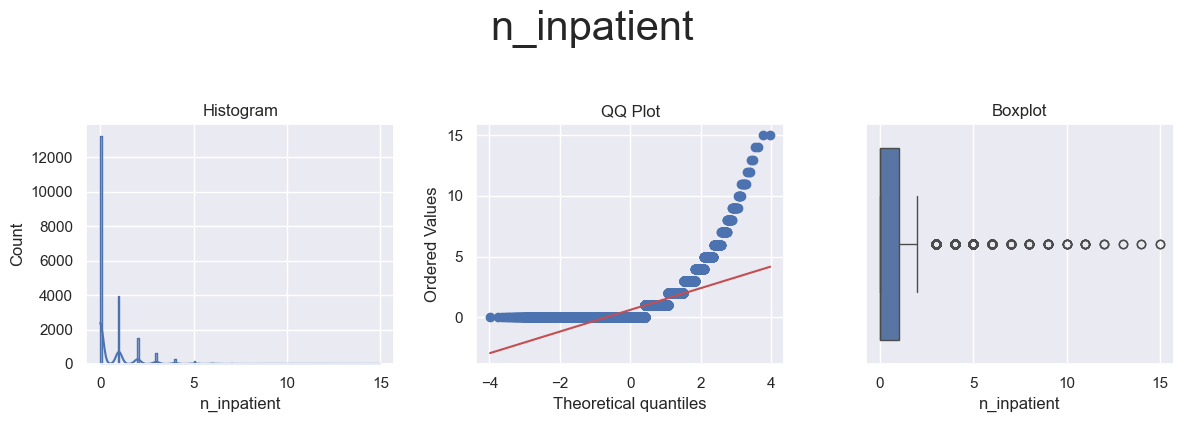

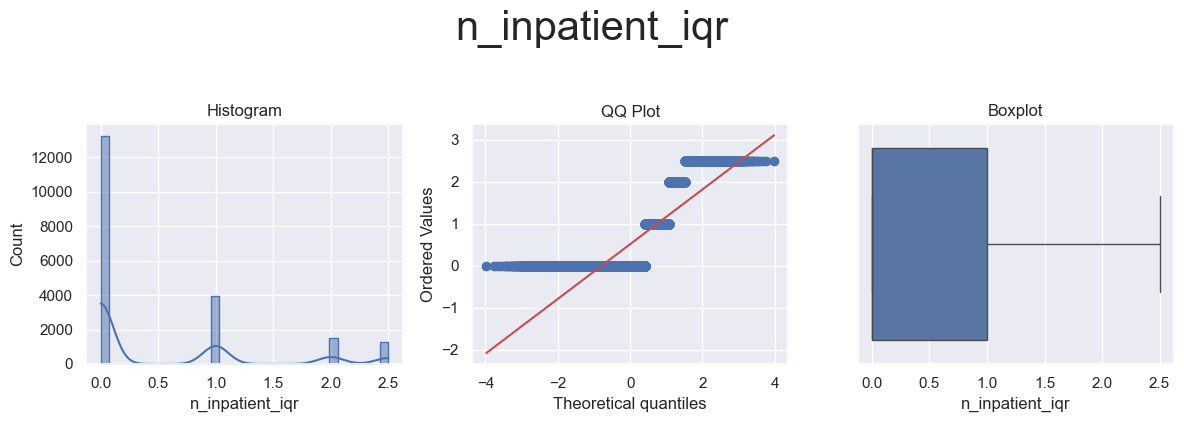

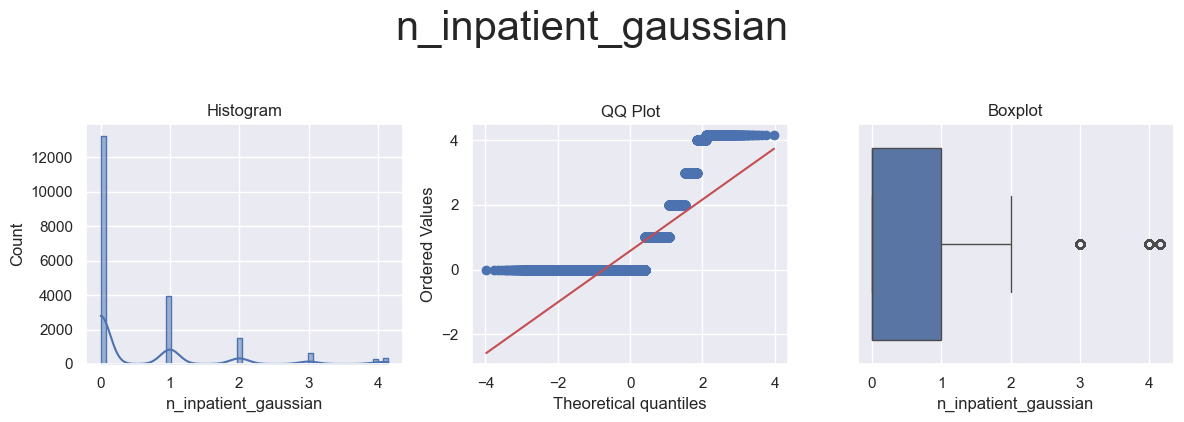



Winsorizer (IQR) failed for n_emergency: Input columns ['n_emergency'] have low variation for method 'iqr'. Try other capping methods or drop these columns.
* Variable Analyzed: n_emergency
* Applied transformation: ['n_emergency_gaussian'] 



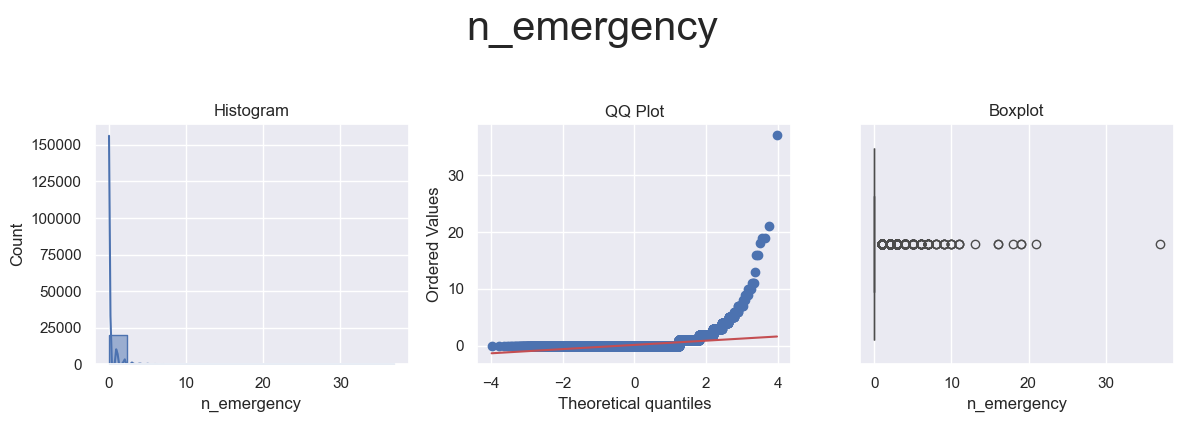

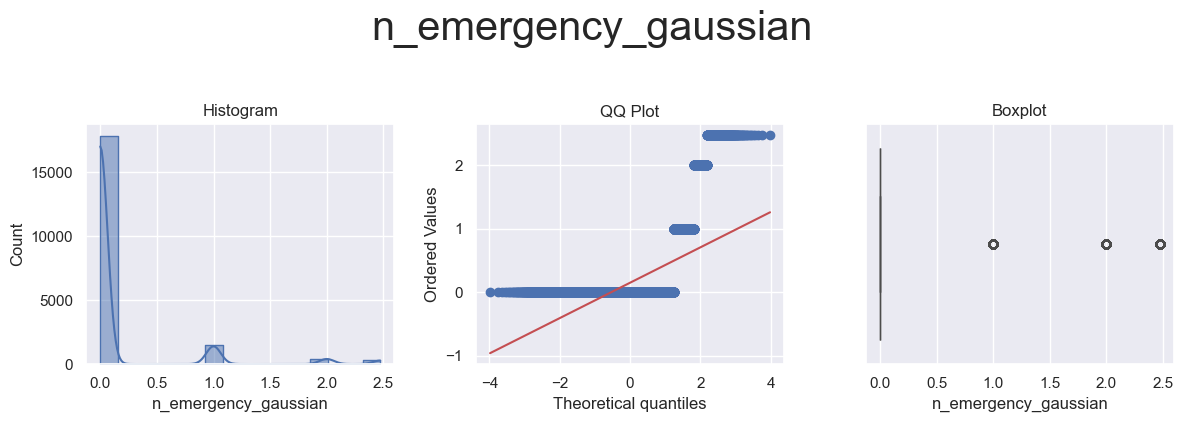



* Variable Analyzed: change
* Applied transformation: ['change_iqr', 'change_gaussian'] 



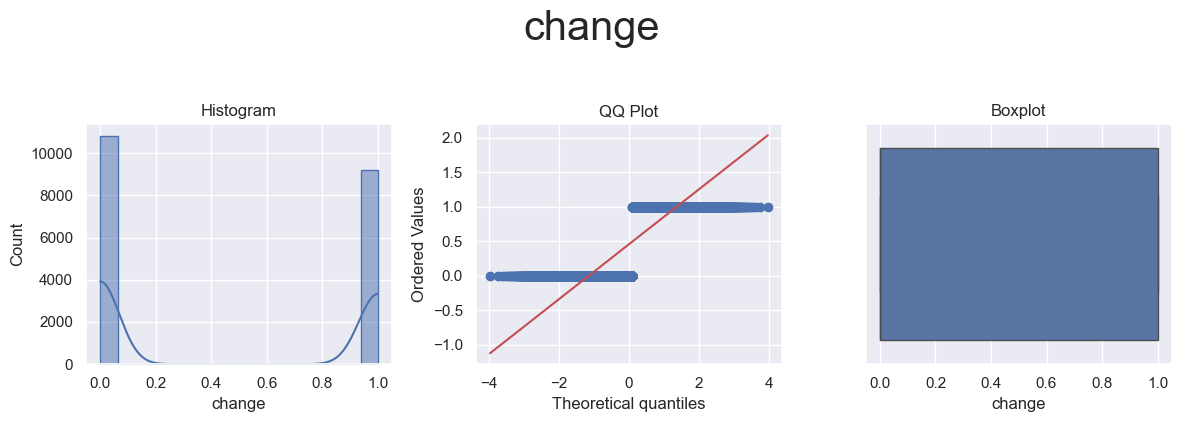

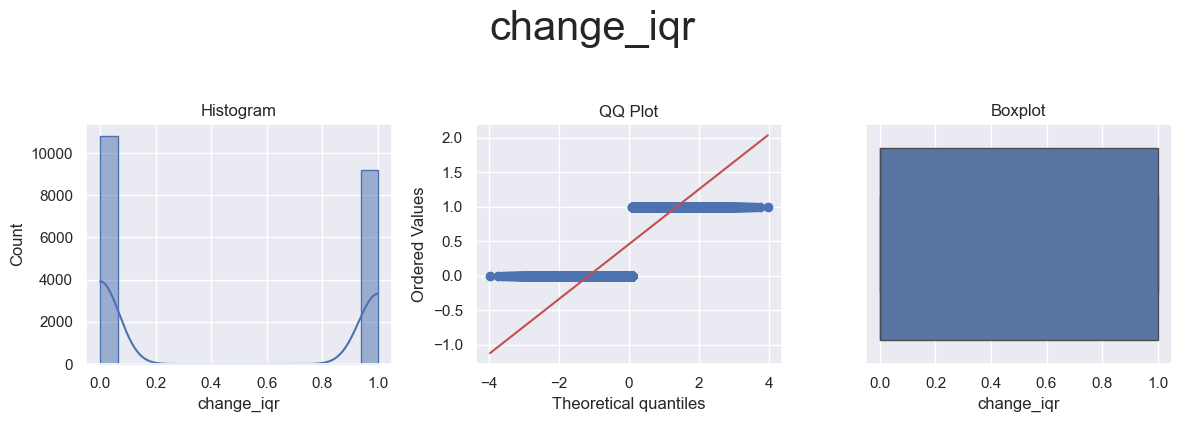

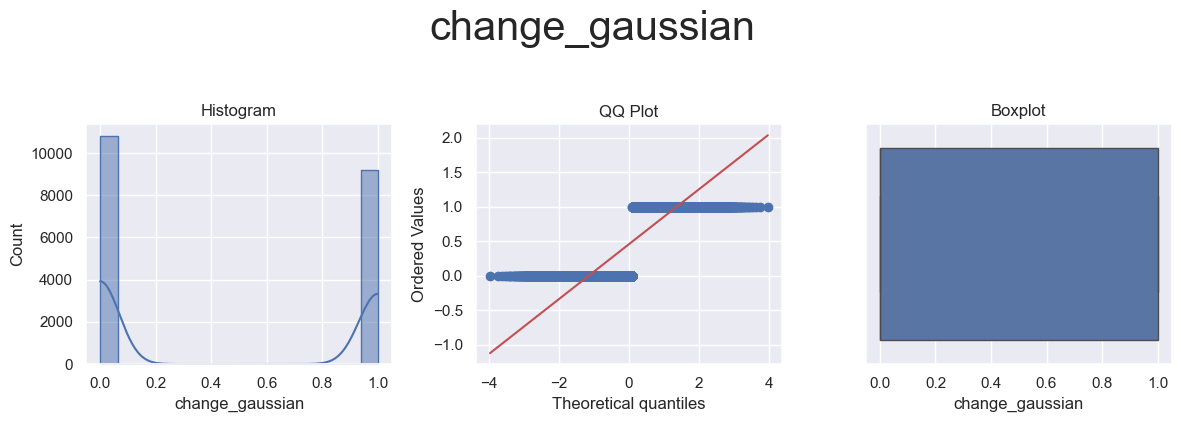



Winsorizer (IQR) failed for diabetes_med: Input columns ['diabetes_med'] have low variation for method 'iqr'. Try other capping methods or drop these columns.
* Variable Analyzed: diabetes_med
* Applied transformation: ['diabetes_med_gaussian'] 



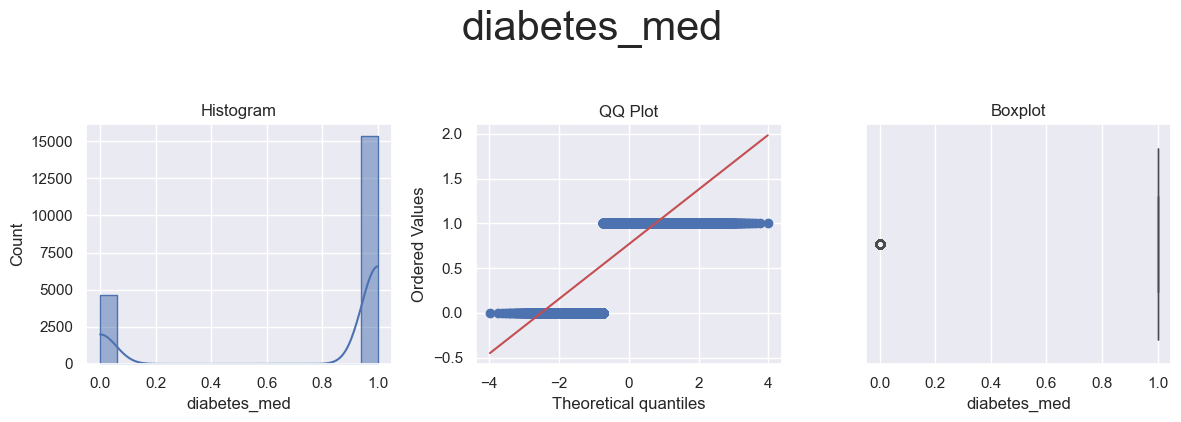

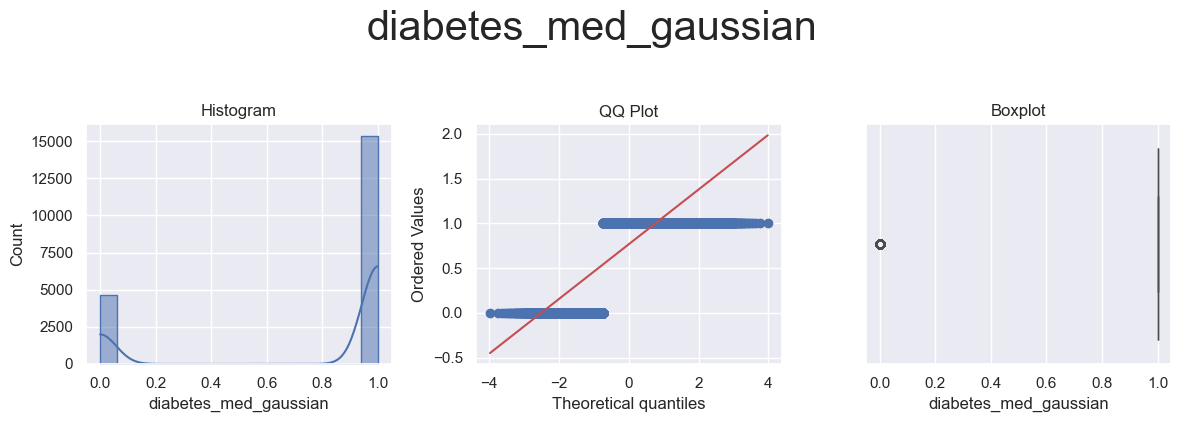

In [13]:
df_num_engineered_outliers = FeatureEngineeringAnalysis(df_num_engineering, analysis_type='outlier_winsorizer')

##### Variance Stabilizing Transformation

* Variable Analyzed: time_in_hospital
* Applied transformation: ['time_in_hospital_log_e', 'time_in_hospital_log_10', 'time_in_hospital_reciprocal', 'time_in_hospital_power', 'time_in_hospital_box_cox', 'time_in_hospital_yeo_johnson'] 



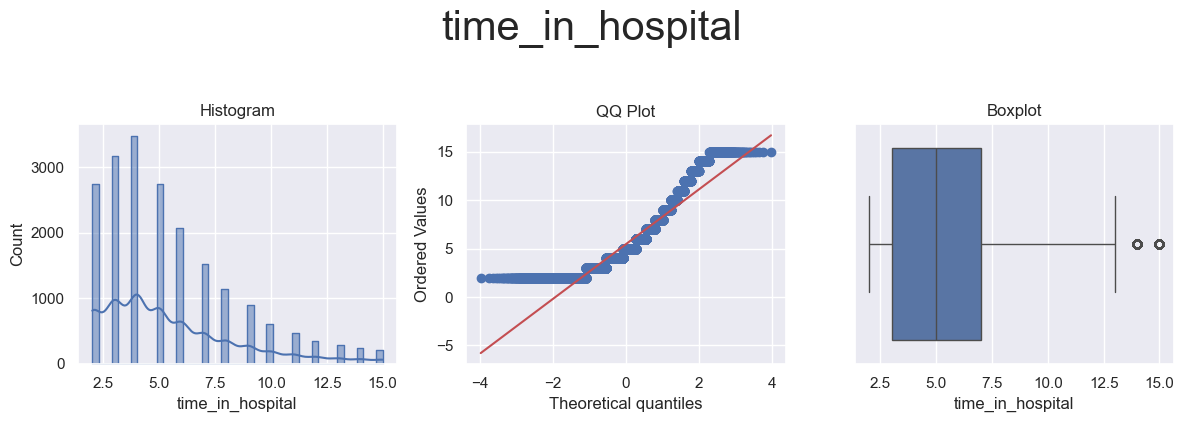

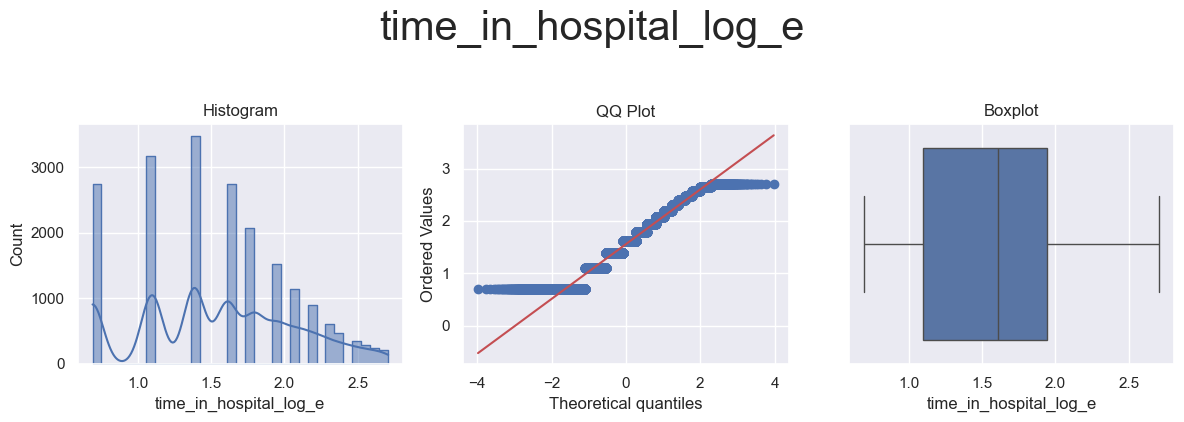

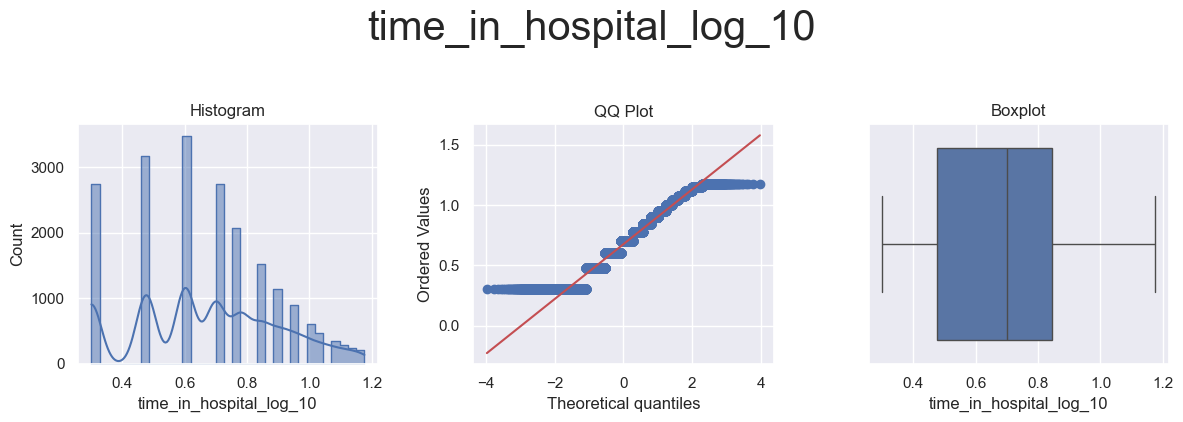

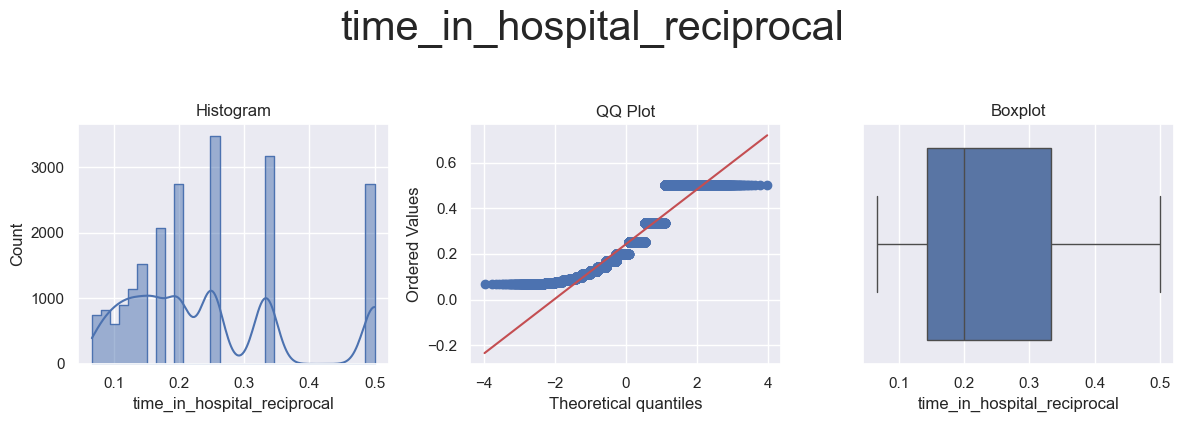

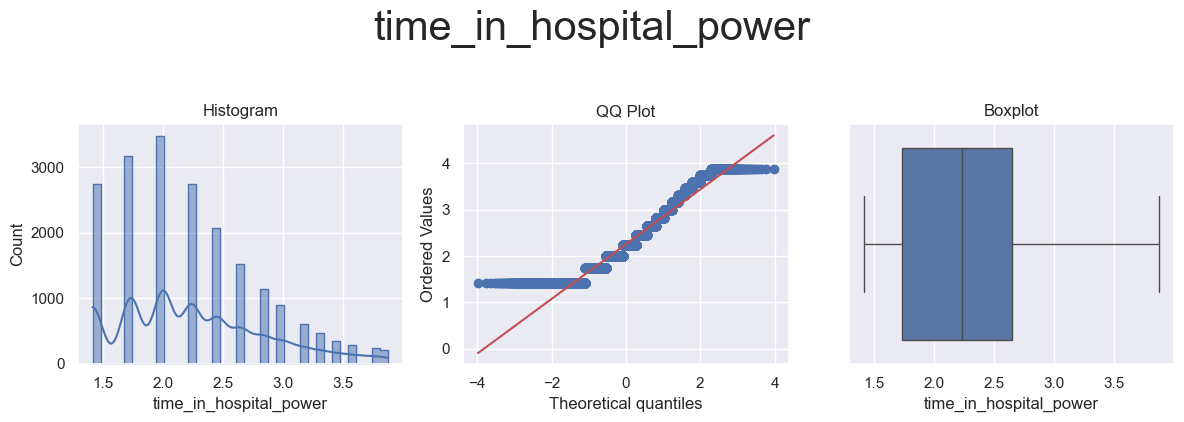

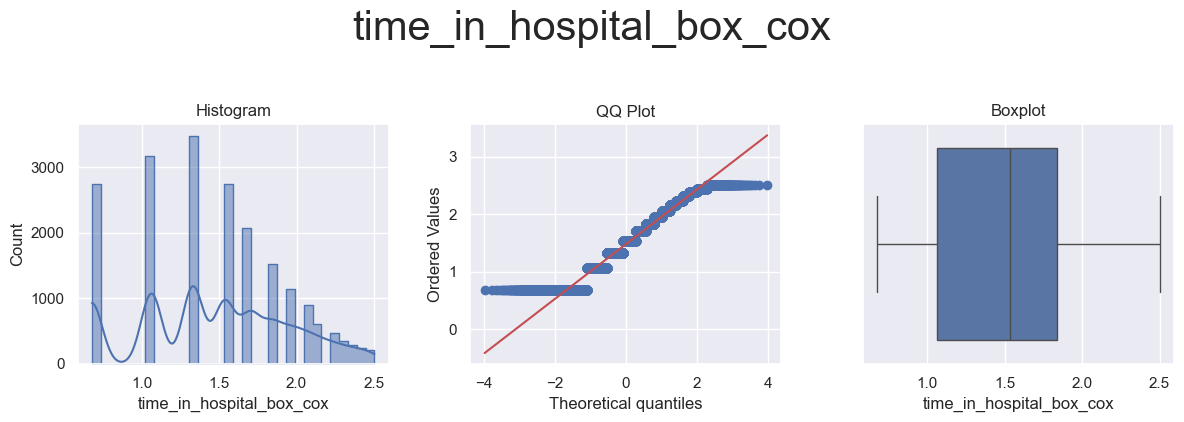

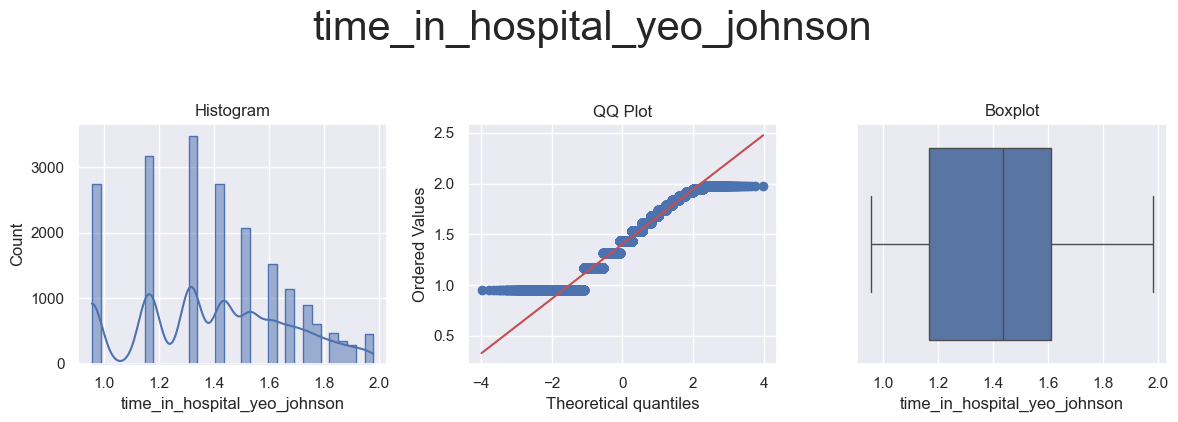



* Variable Analyzed: n_lab_procedures
* Applied transformation: ['n_lab_procedures_log_e', 'n_lab_procedures_log_10', 'n_lab_procedures_reciprocal', 'n_lab_procedures_power', 'n_lab_procedures_box_cox', 'n_lab_procedures_yeo_johnson'] 



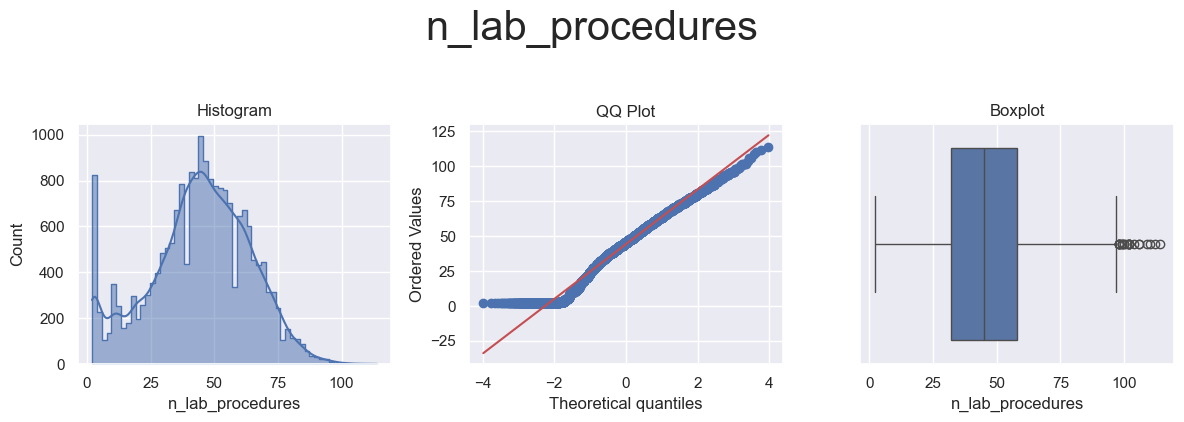

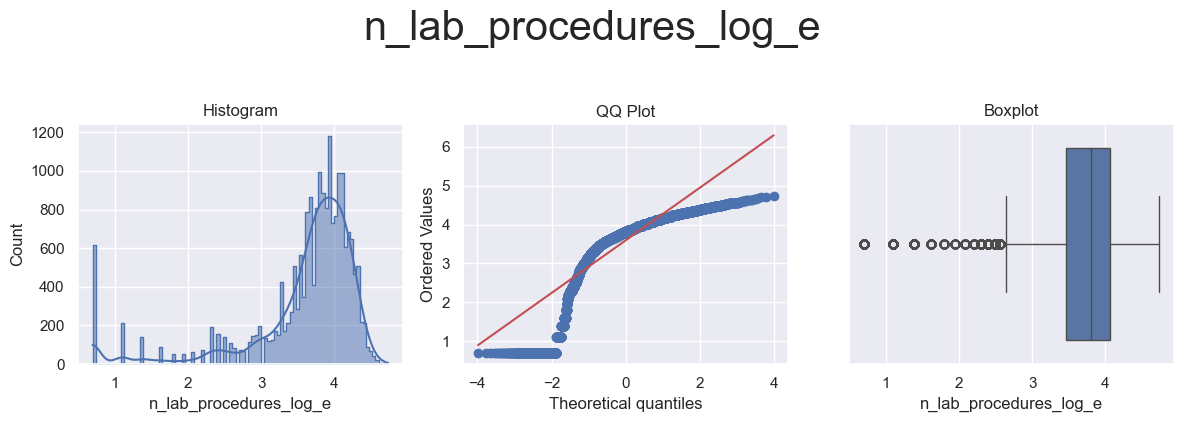

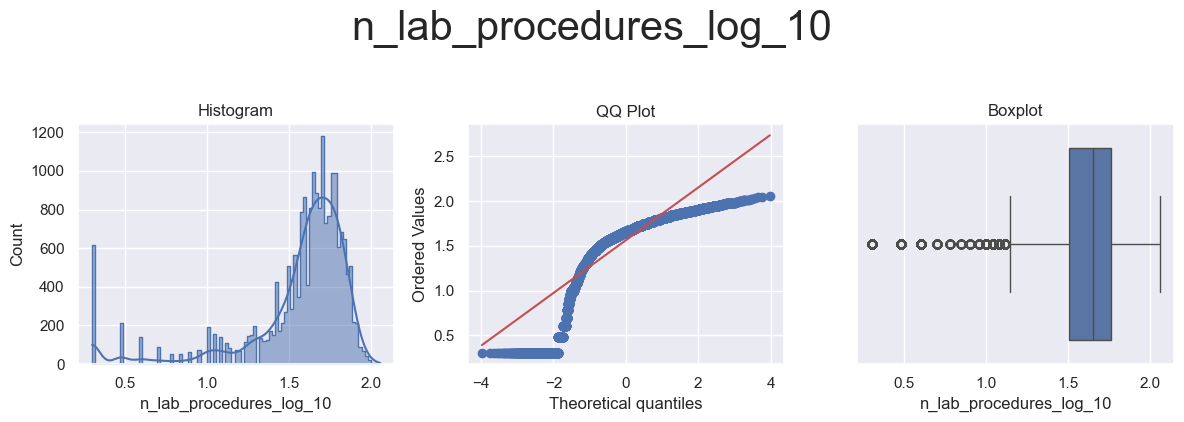

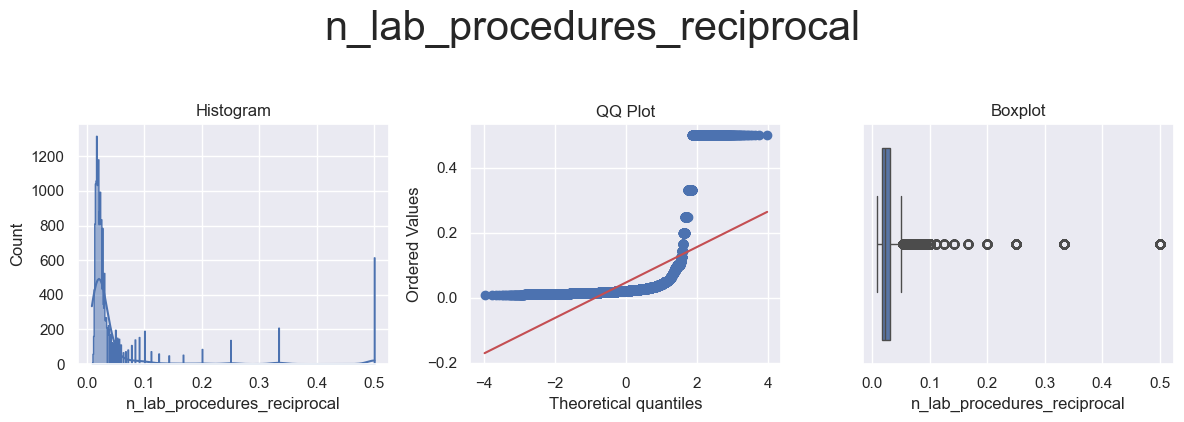

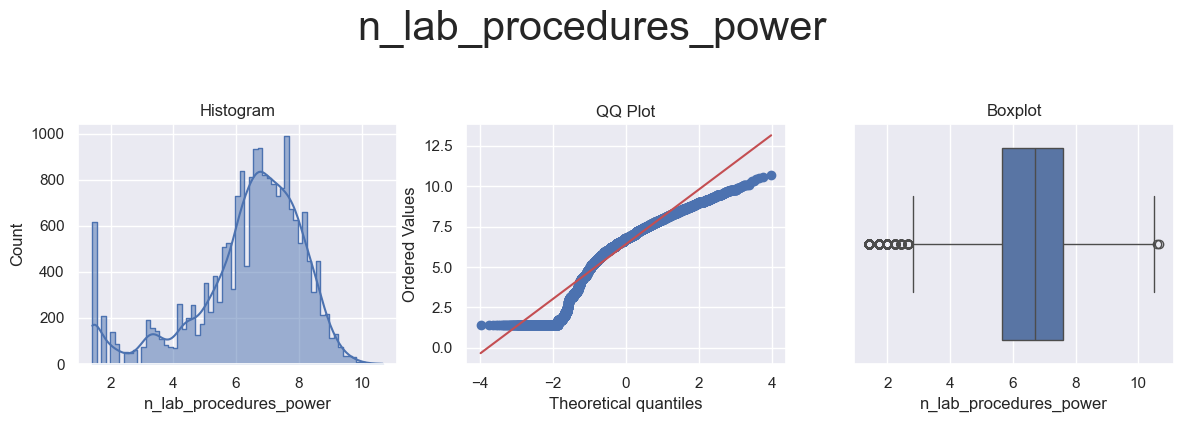

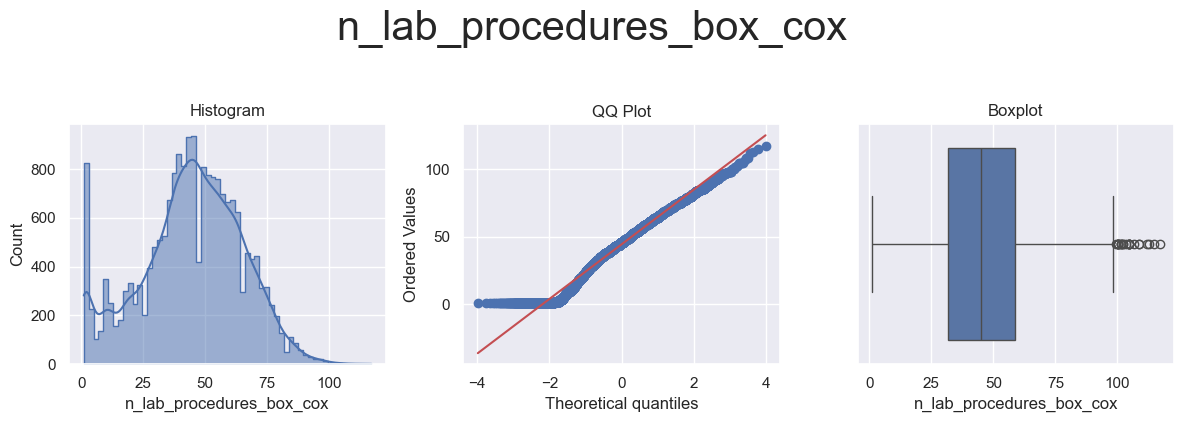

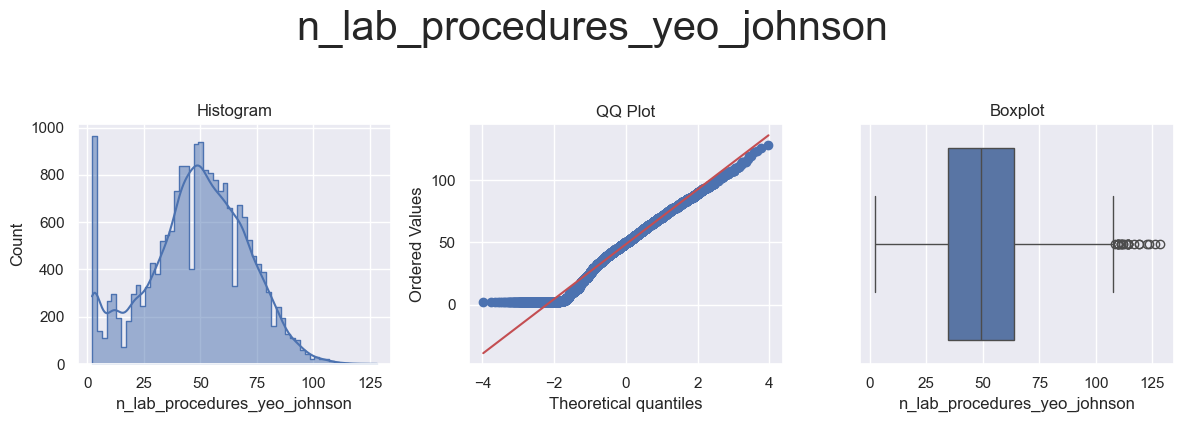



* Variable Analyzed: n_procedures
* Applied transformation: ['n_procedures_log_e', 'n_procedures_log_10', 'n_procedures_reciprocal', 'n_procedures_power', 'n_procedures_box_cox', 'n_procedures_yeo_johnson'] 



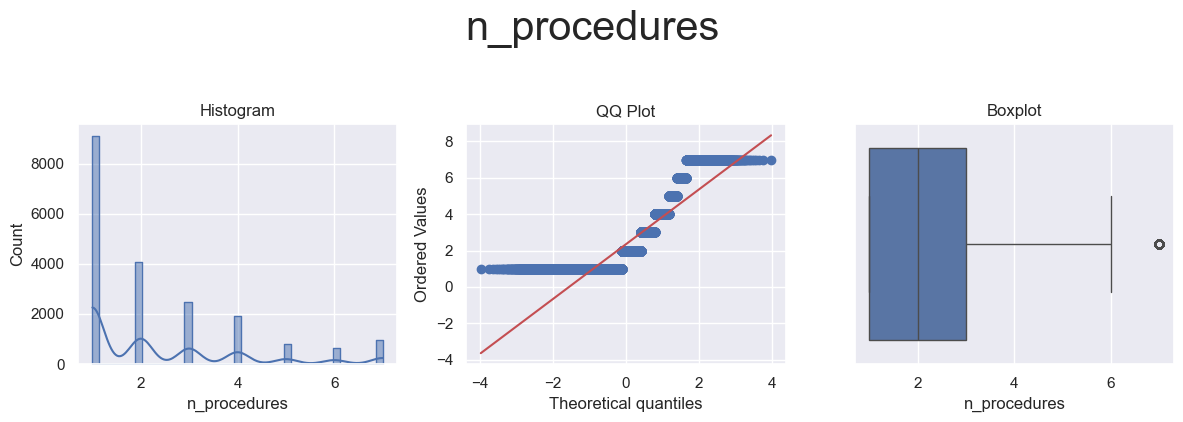

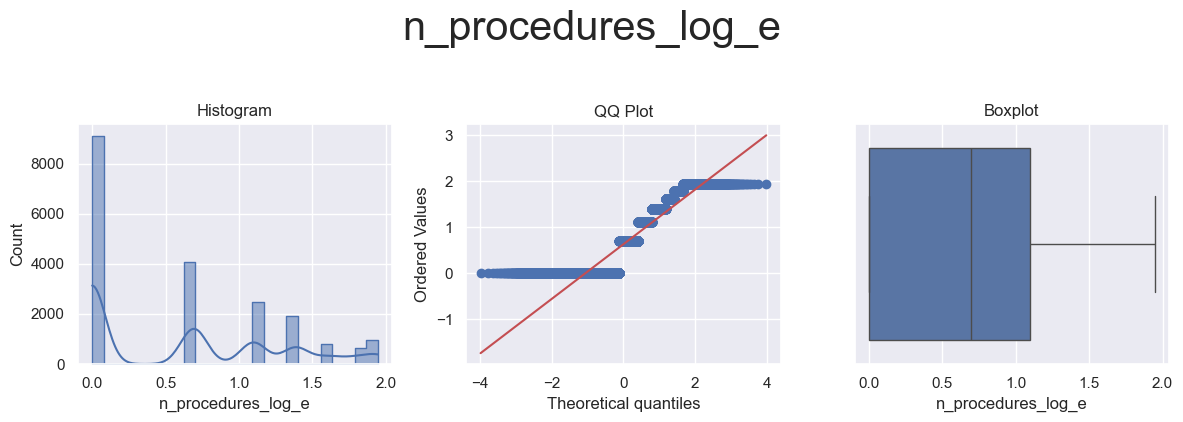

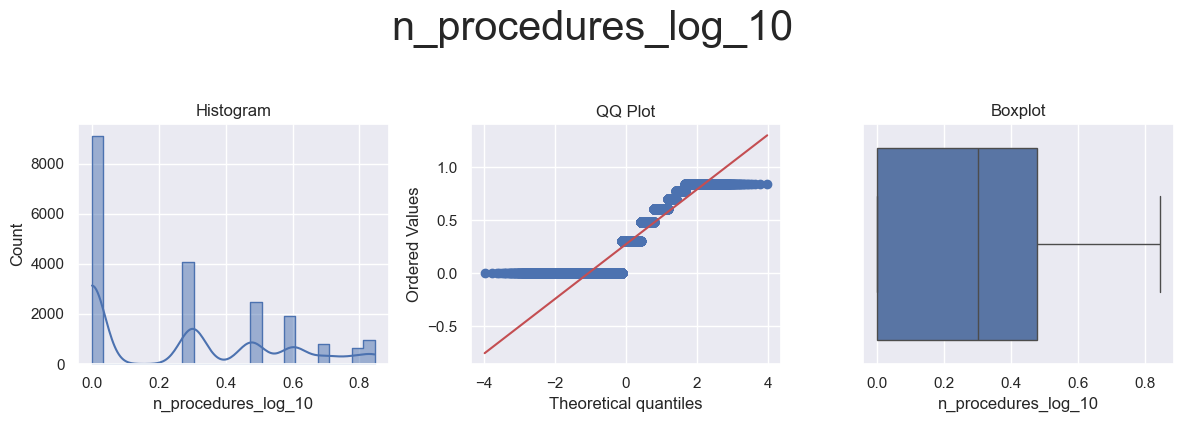

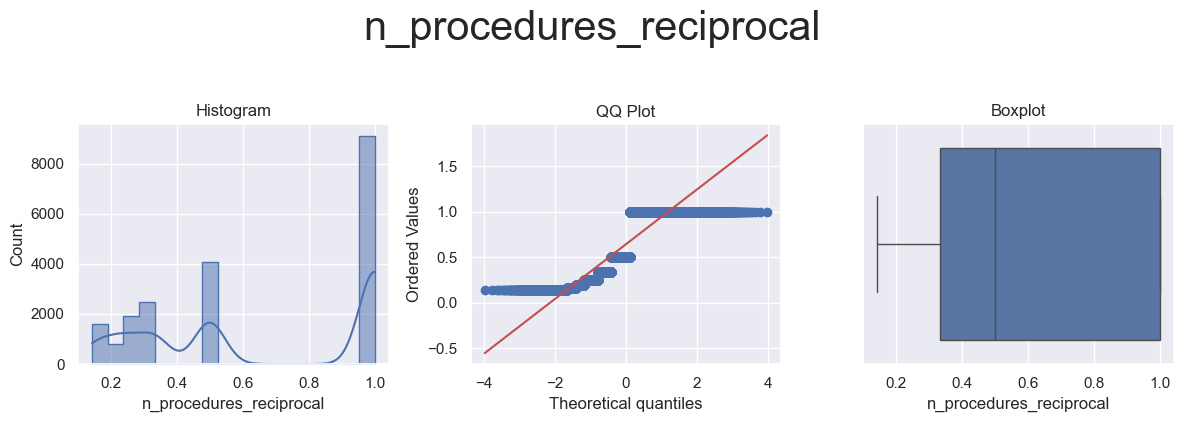

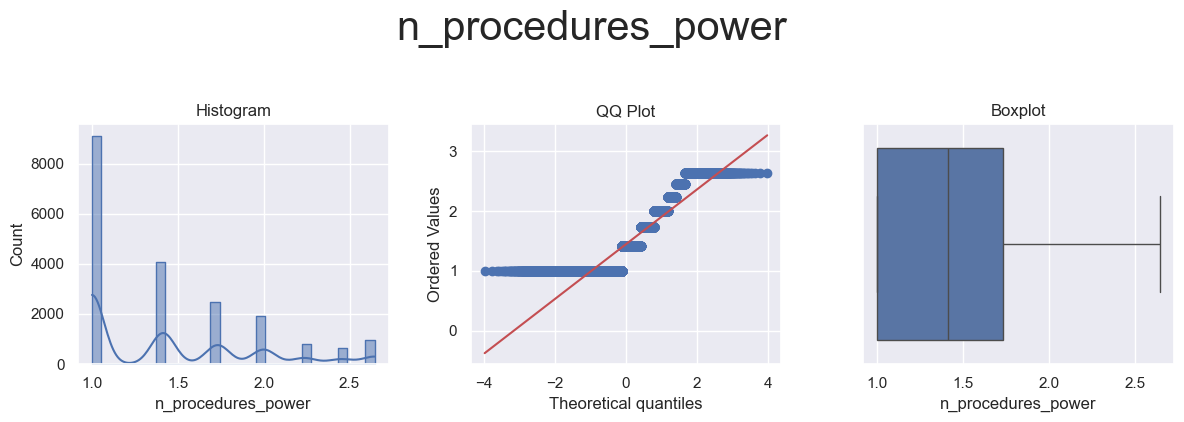

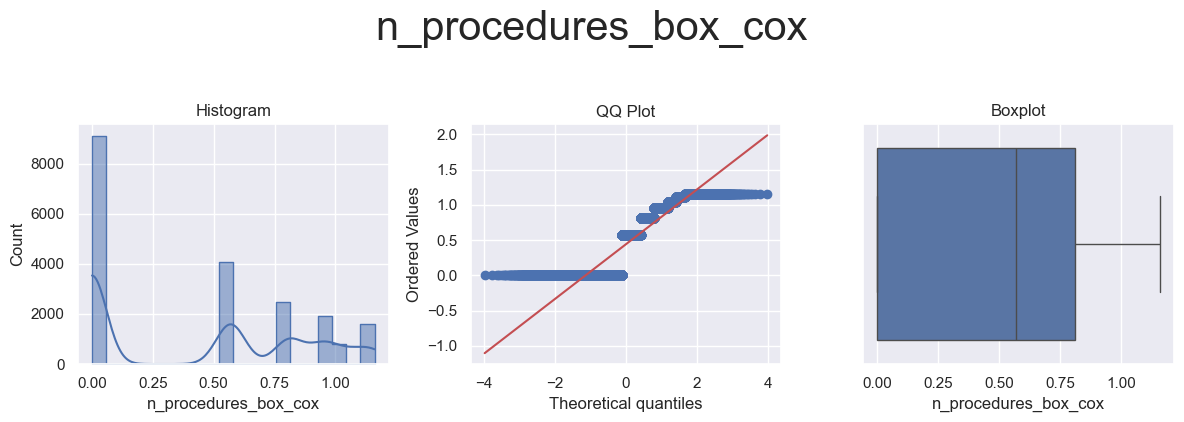

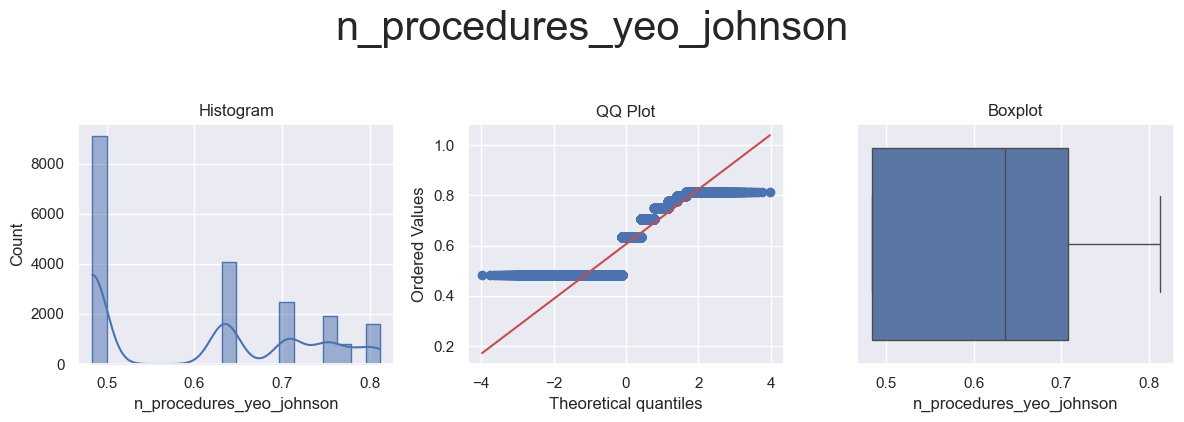



* Variable Analyzed: n_medications
* Applied transformation: ['n_medications_log_e', 'n_medications_log_10', 'n_medications_reciprocal', 'n_medications_power', 'n_medications_box_cox', 'n_medications_yeo_johnson'] 



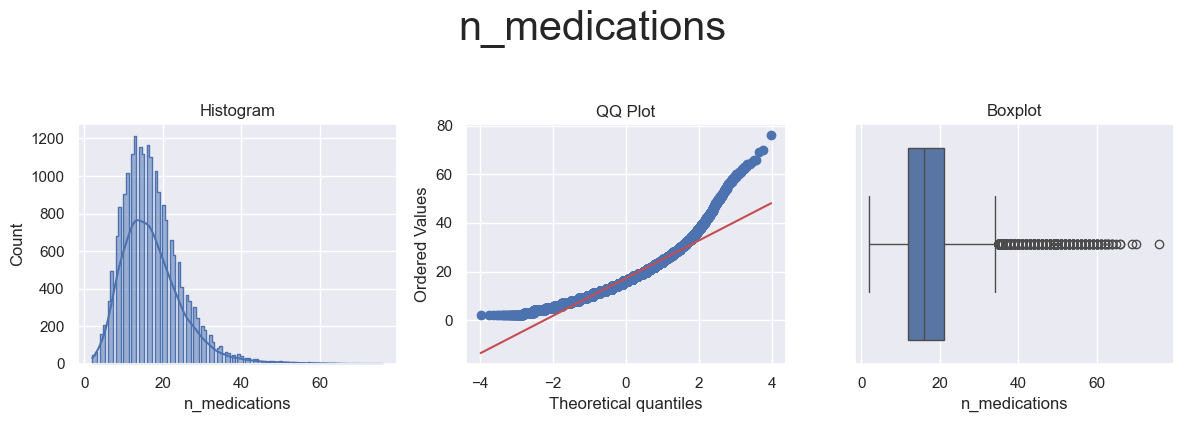

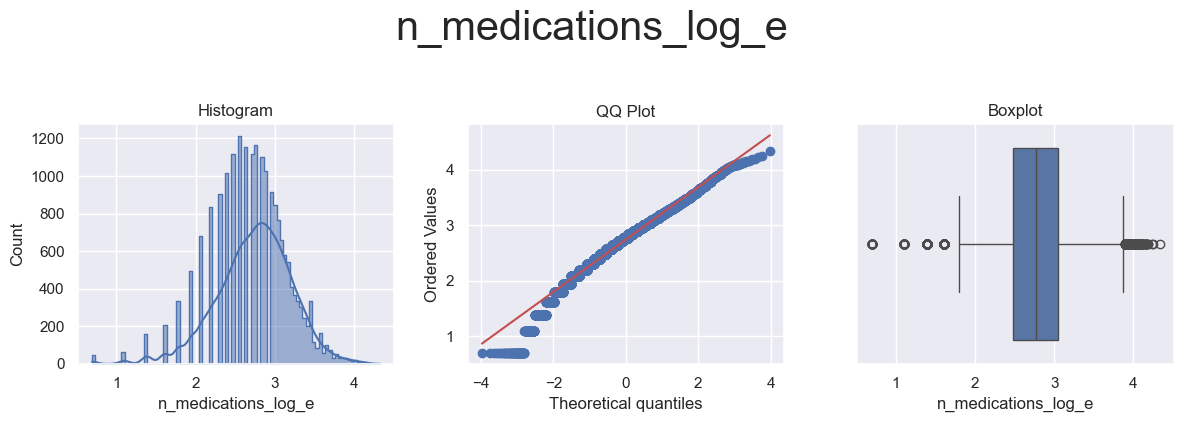

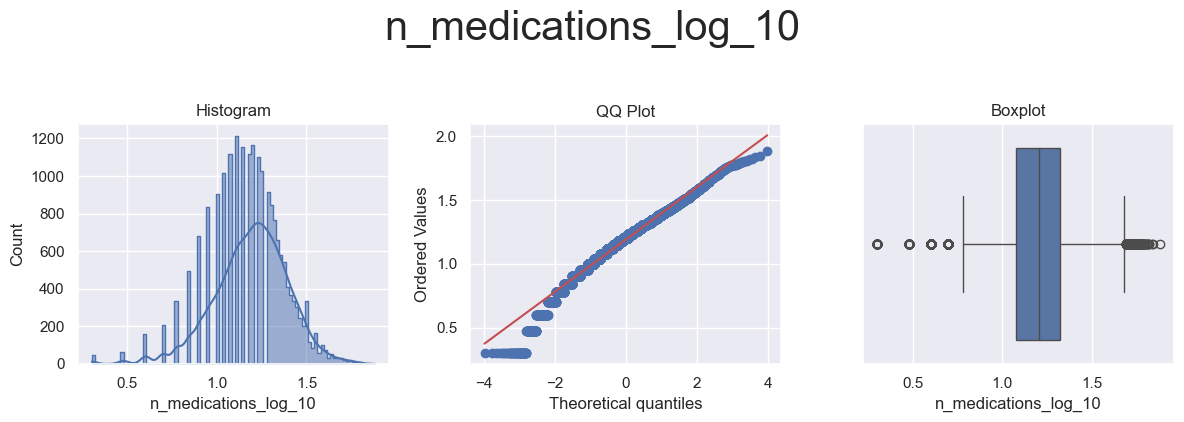

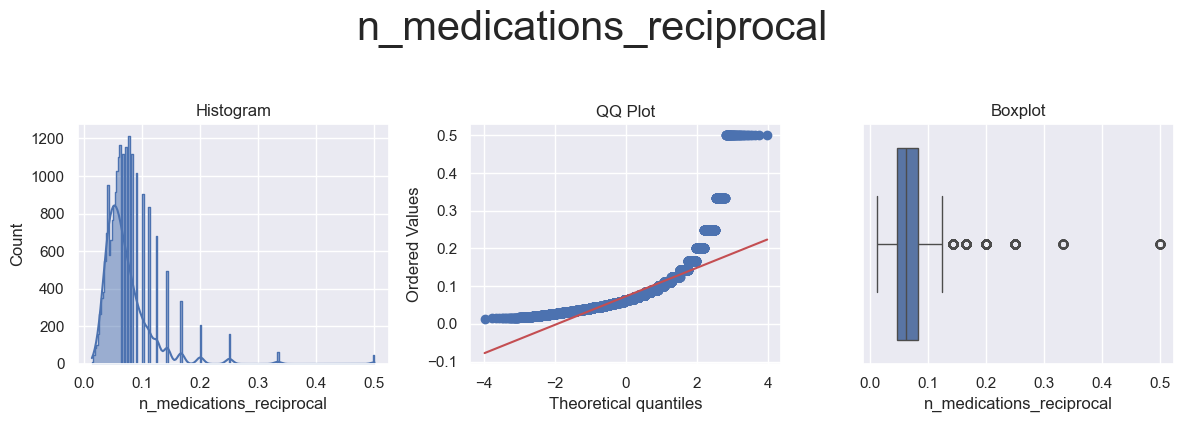

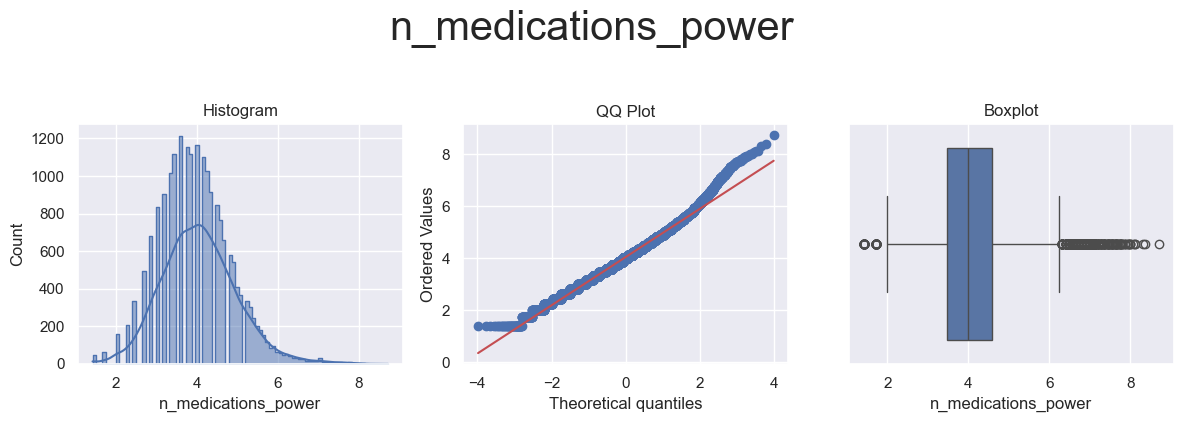

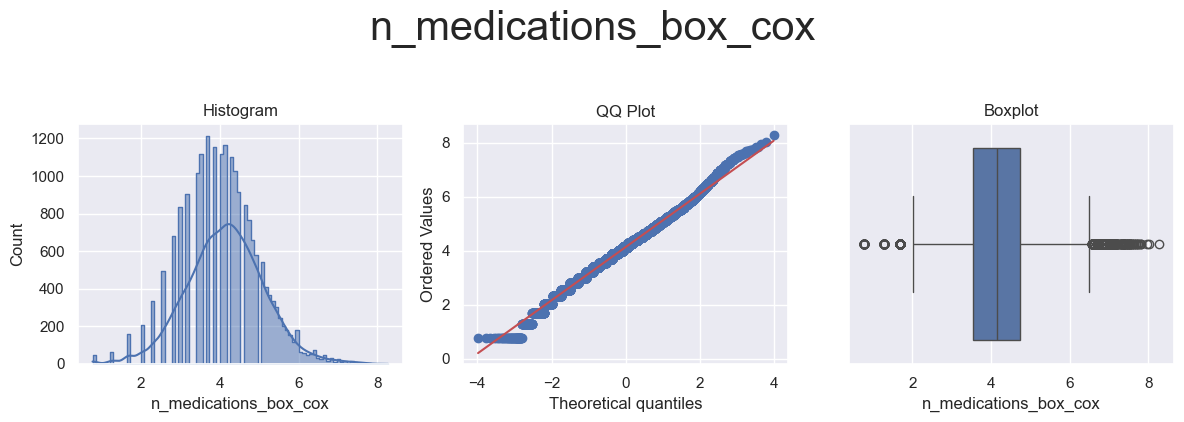

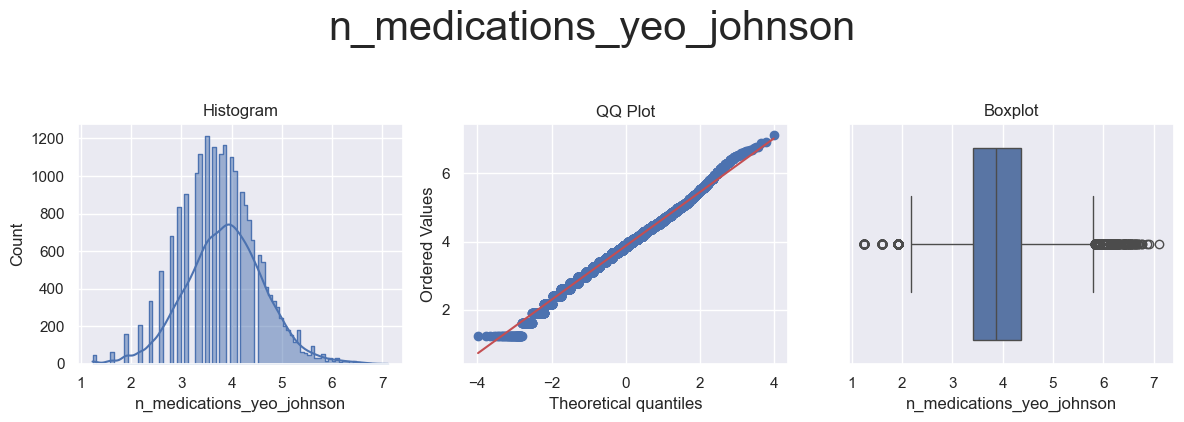



* Variable Analyzed: n_outpatient
* Applied transformation: ['n_outpatient_log_e', 'n_outpatient_log_10', 'n_outpatient_reciprocal', 'n_outpatient_power', 'n_outpatient_box_cox', 'n_outpatient_yeo_johnson'] 



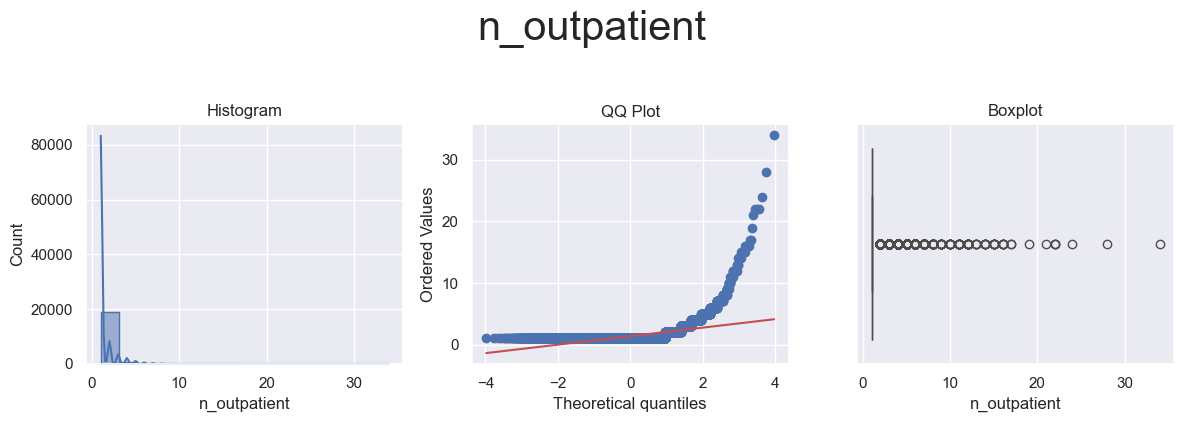

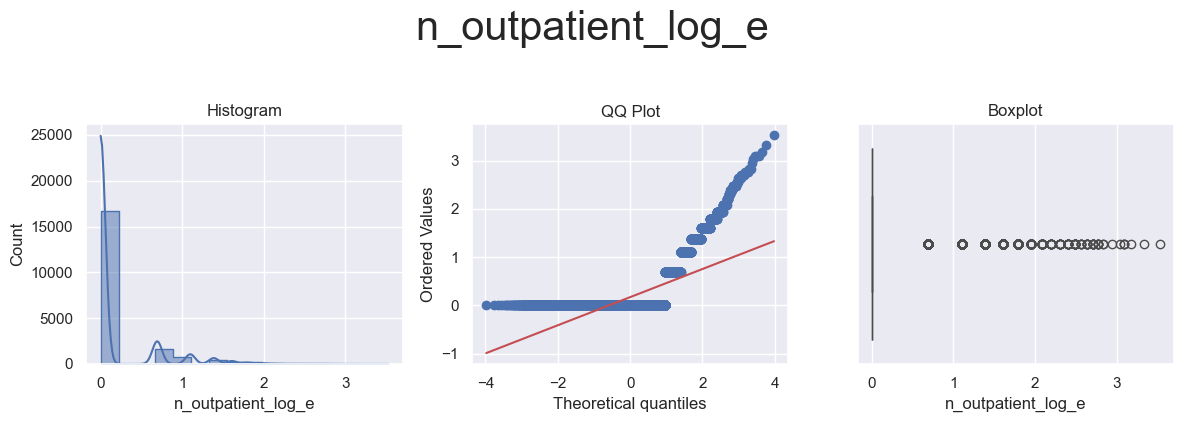

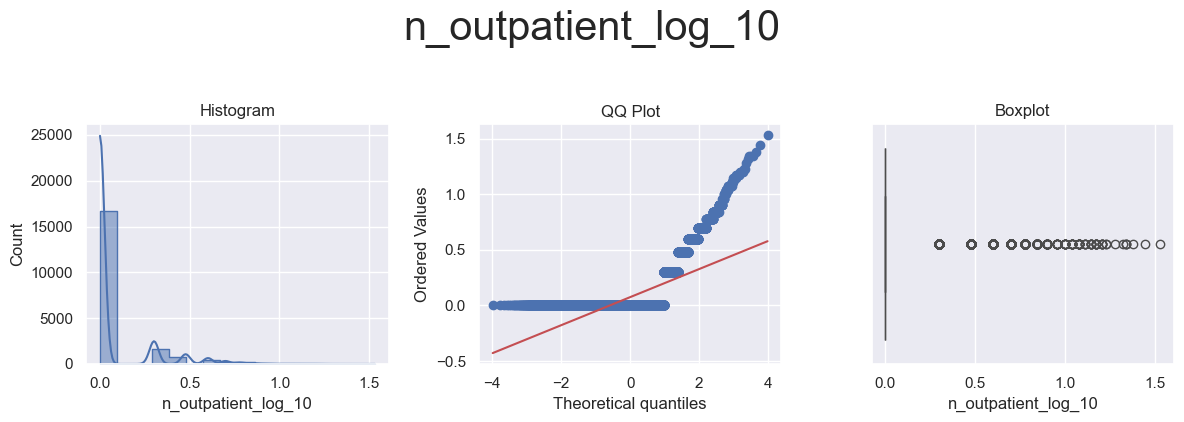

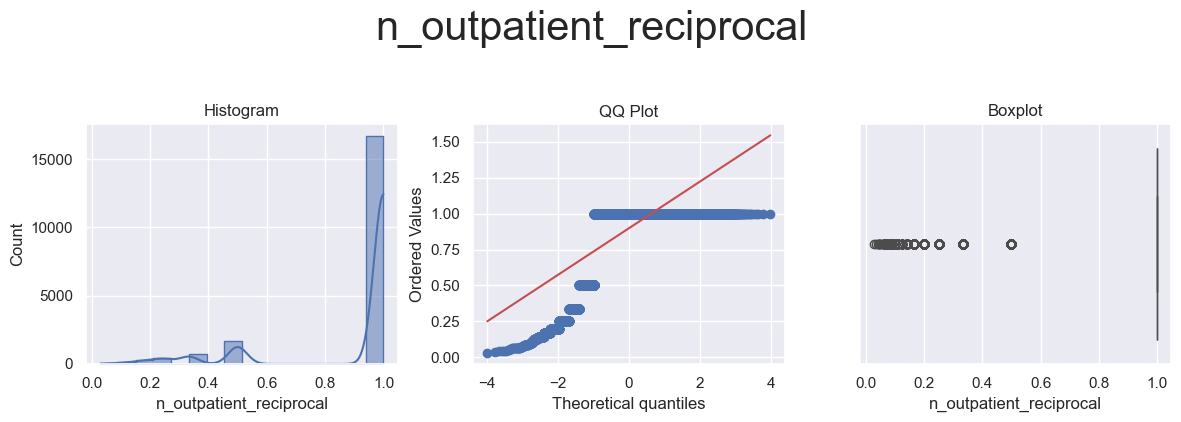

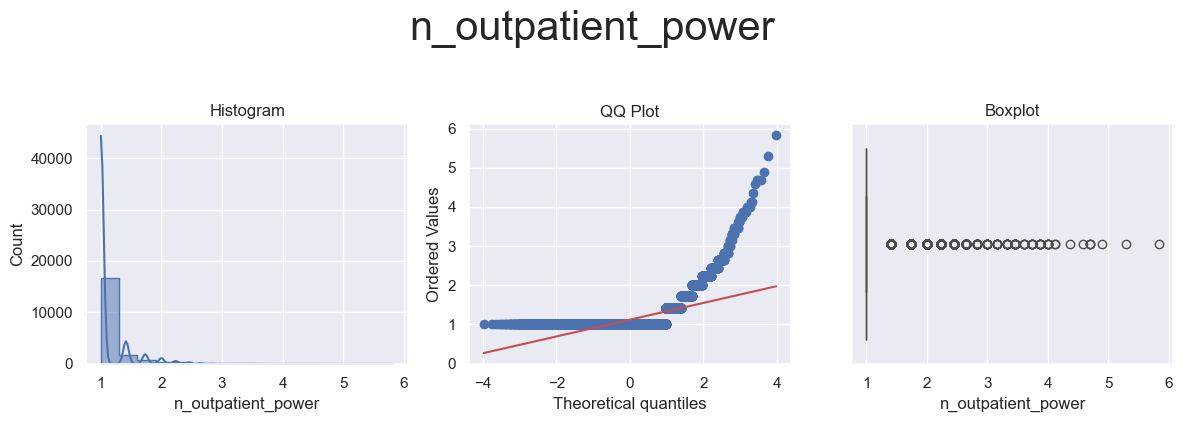

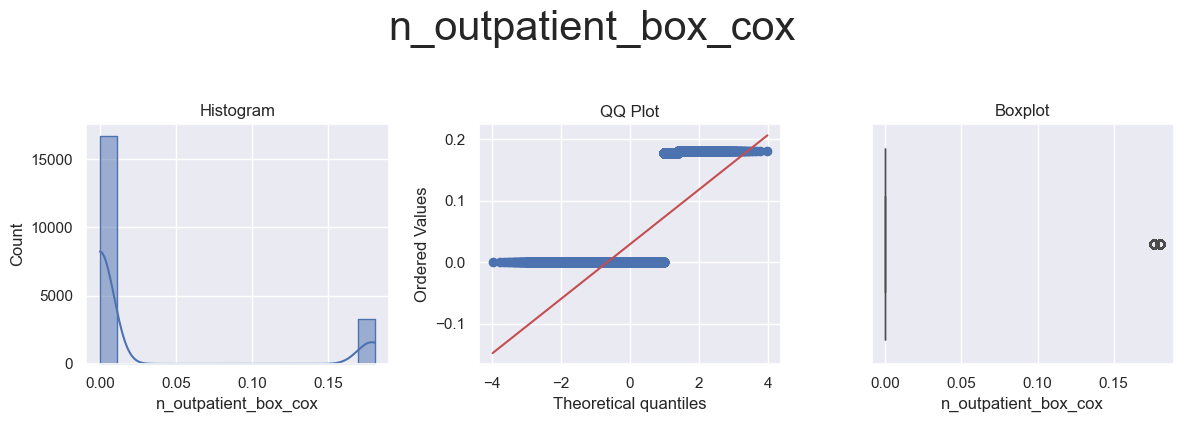

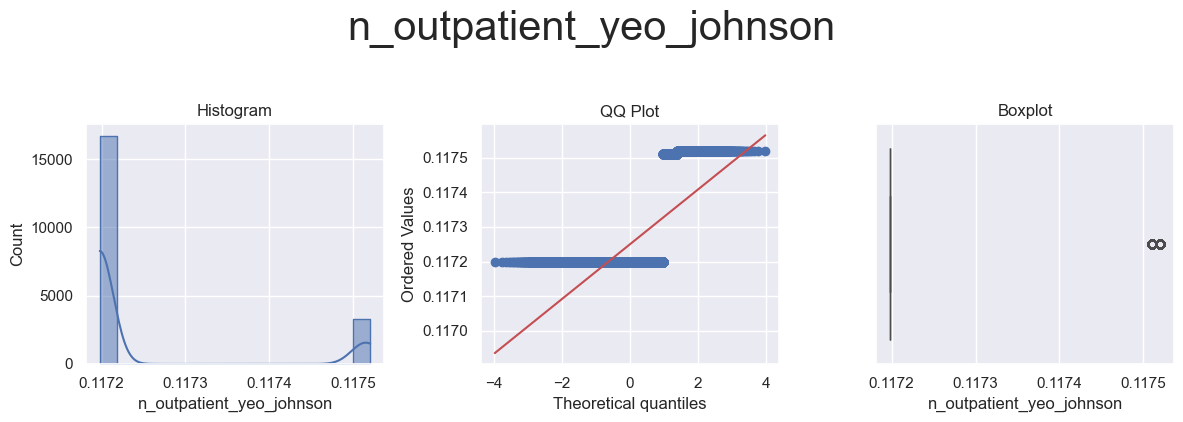



* Variable Analyzed: n_inpatient
* Applied transformation: ['n_inpatient_log_e', 'n_inpatient_log_10', 'n_inpatient_reciprocal', 'n_inpatient_power', 'n_inpatient_box_cox', 'n_inpatient_yeo_johnson'] 



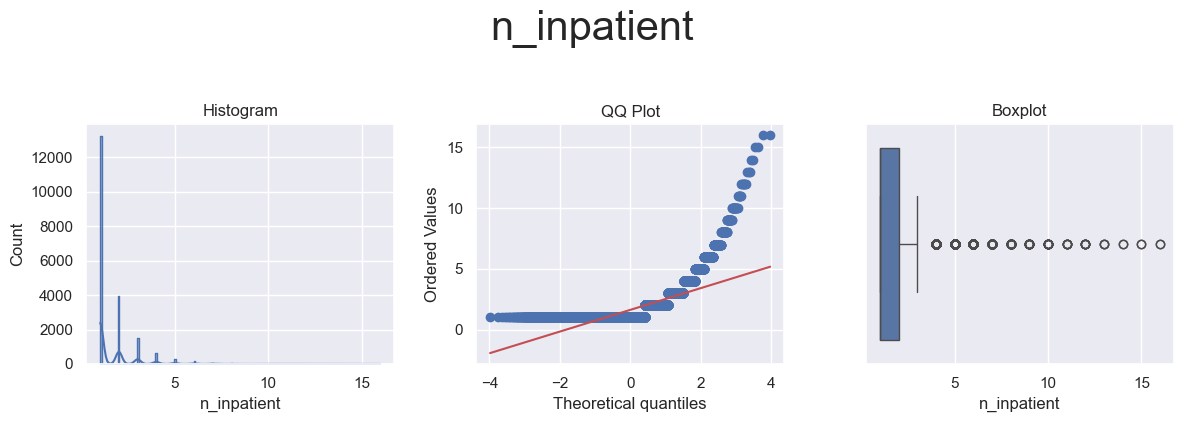

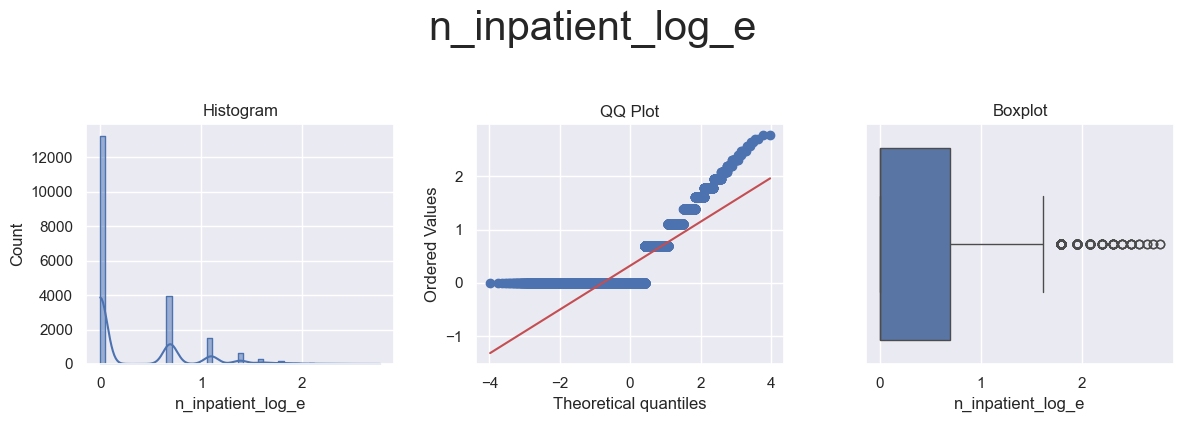

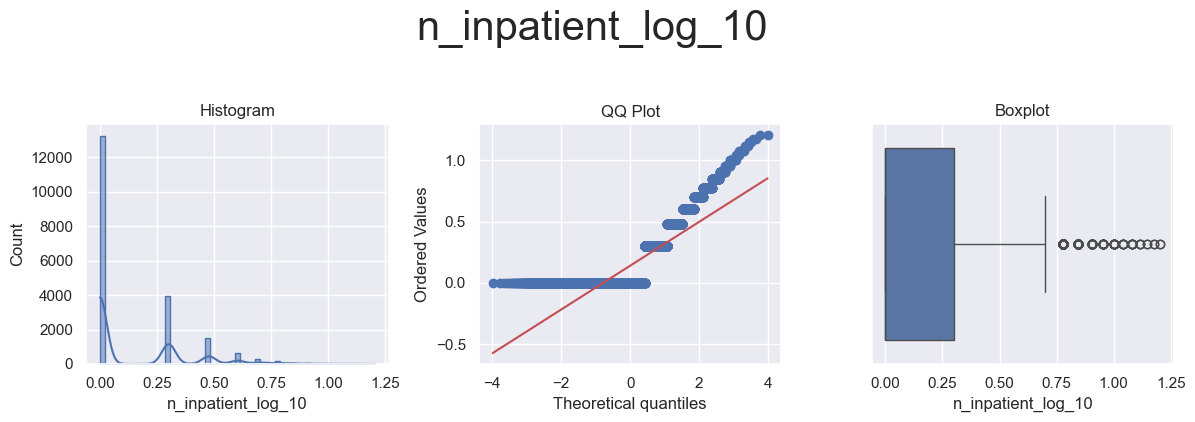

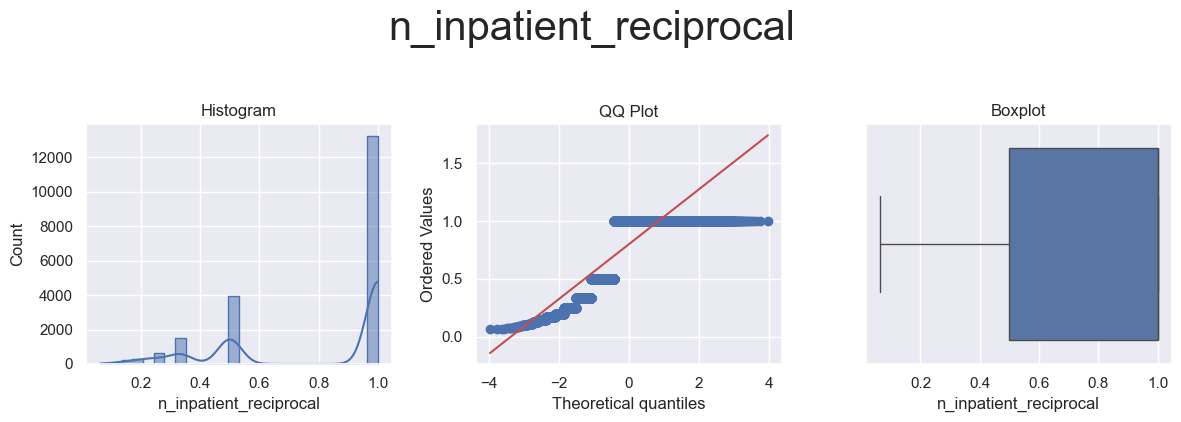

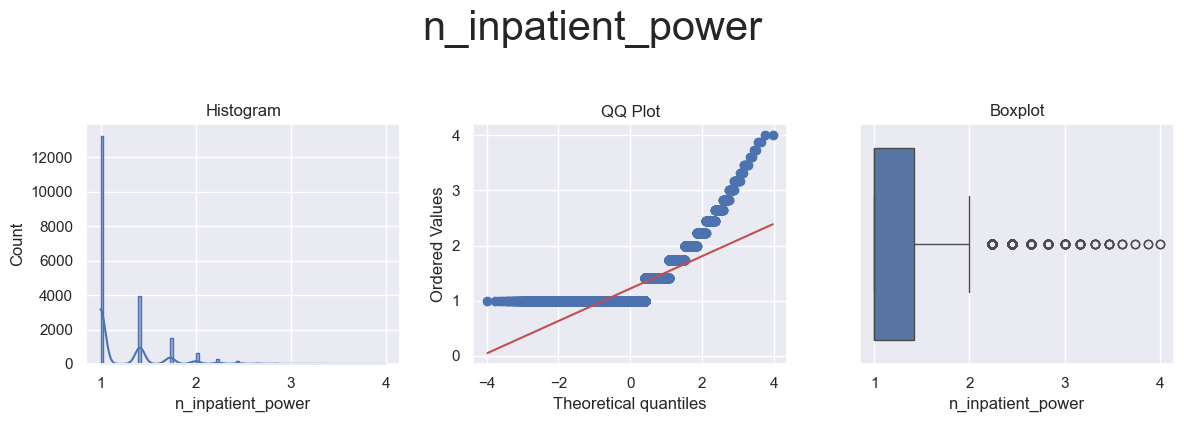

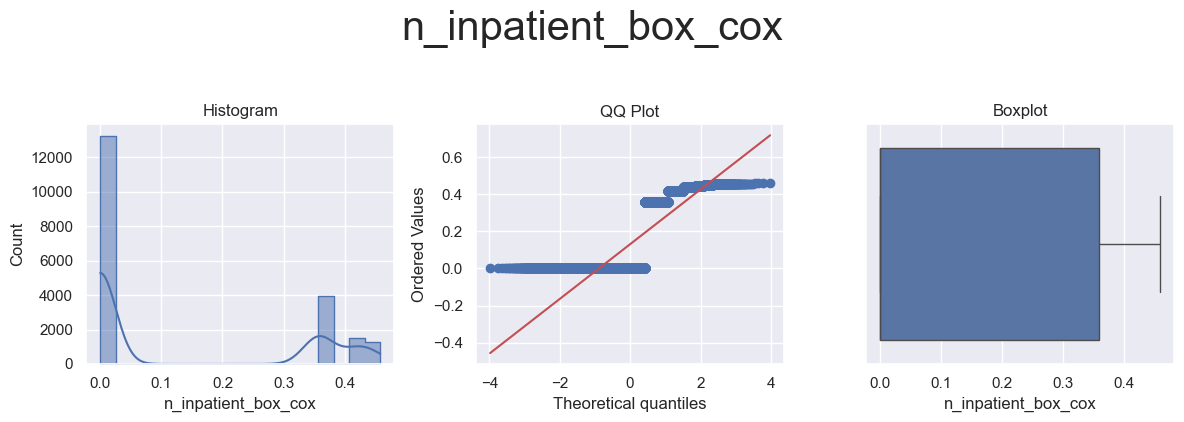

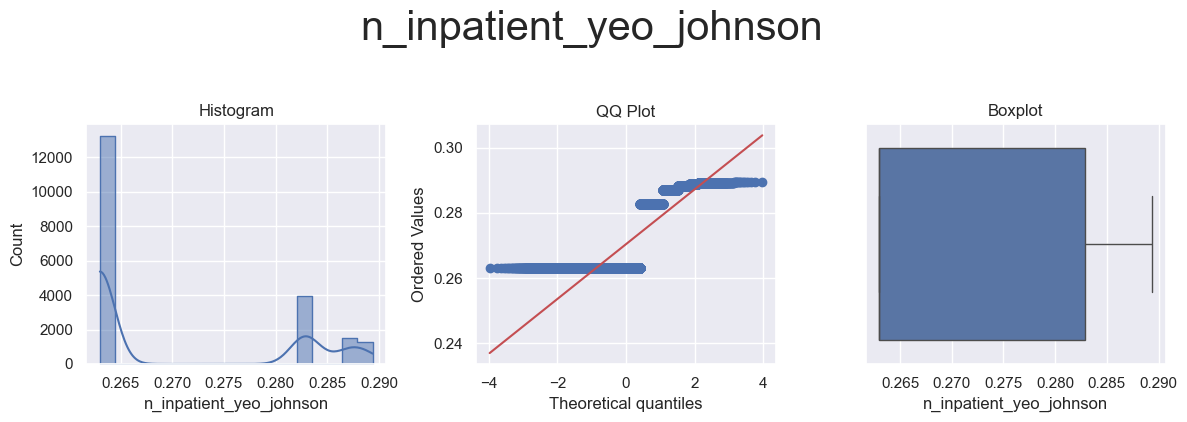



* Variable Analyzed: n_emergency
* Applied transformation: ['n_emergency_log_e', 'n_emergency_log_10', 'n_emergency_reciprocal', 'n_emergency_power', 'n_emergency_box_cox', 'n_emergency_yeo_johnson'] 



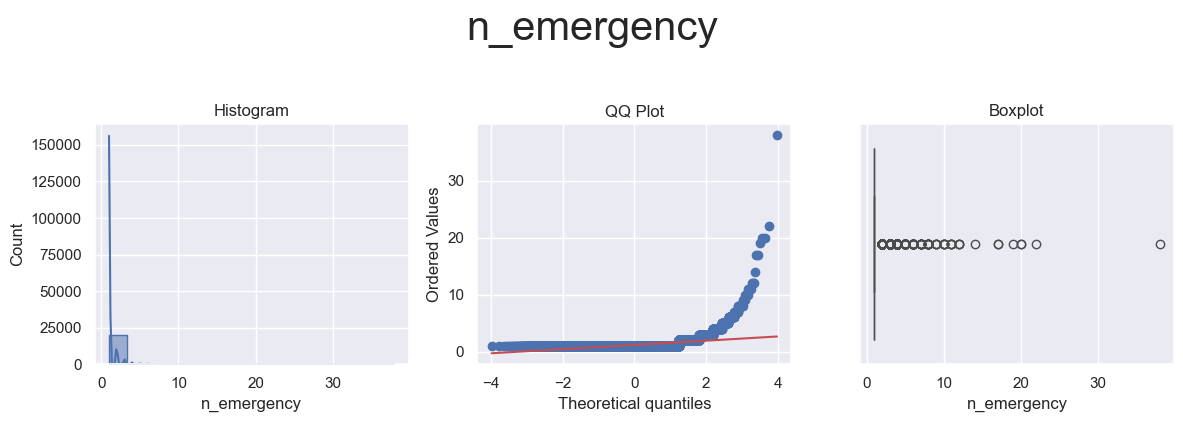

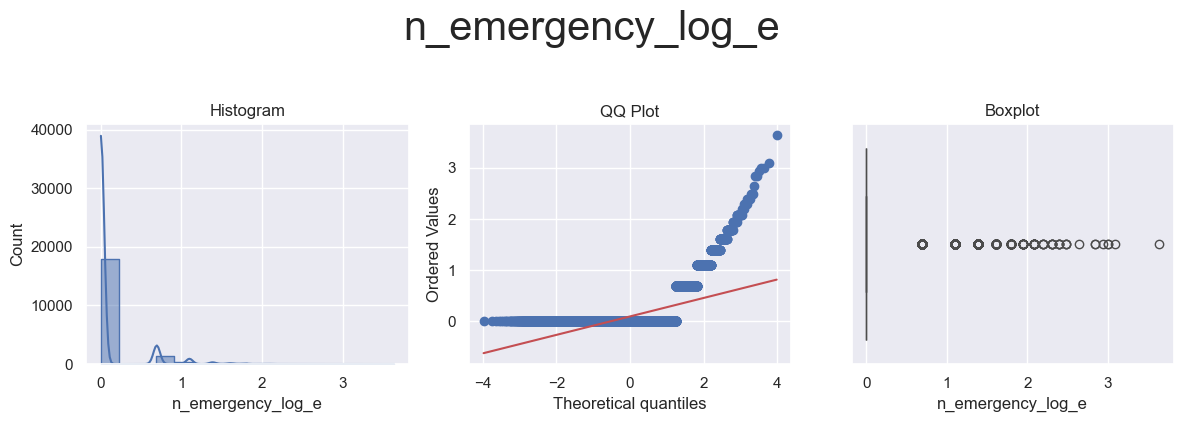

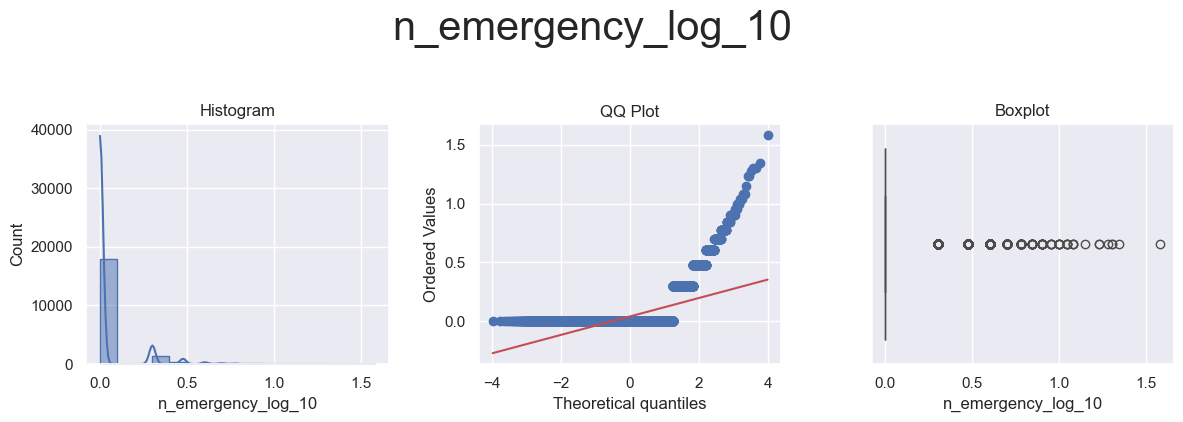

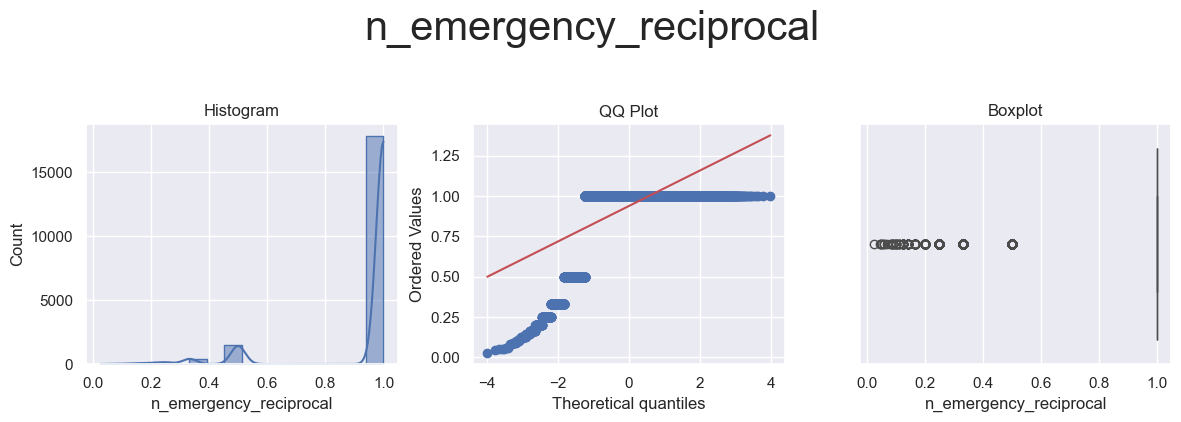

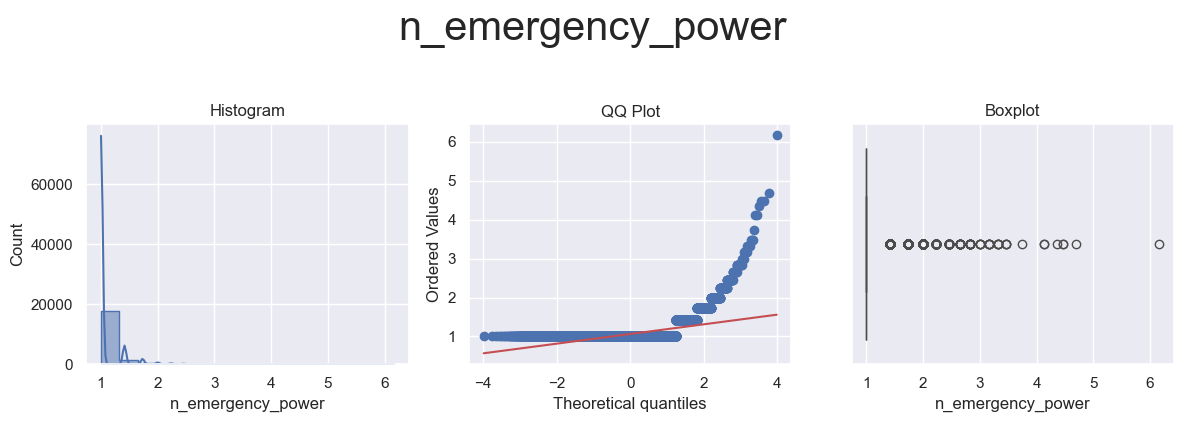

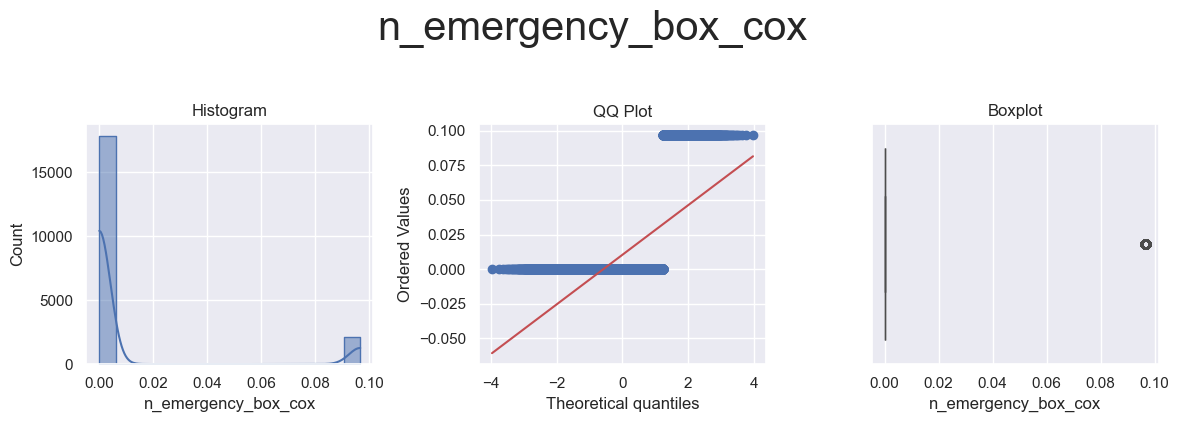

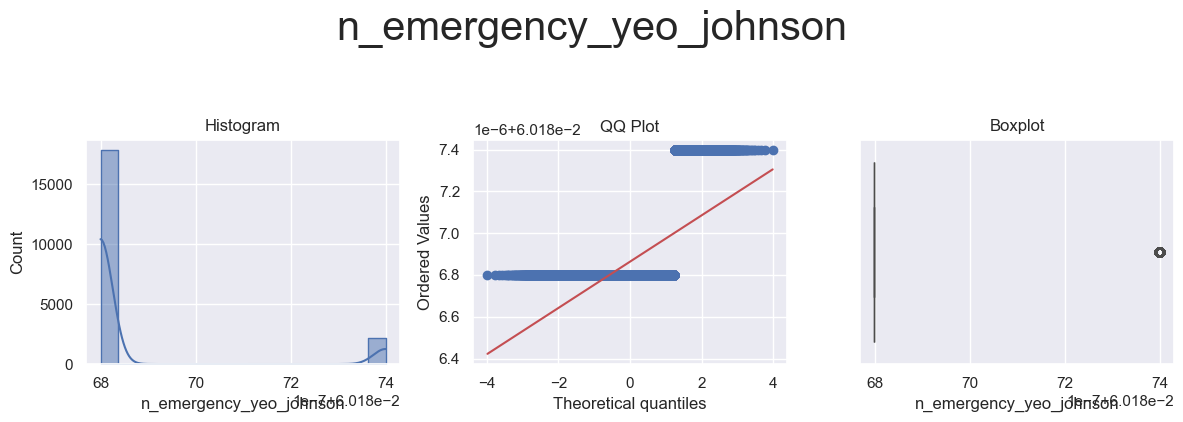



* Variable Analyzed: change
* Applied transformation: ['change_log_e', 'change_log_10', 'change_reciprocal', 'change_power', 'change_box_cox', 'change_yeo_johnson'] 



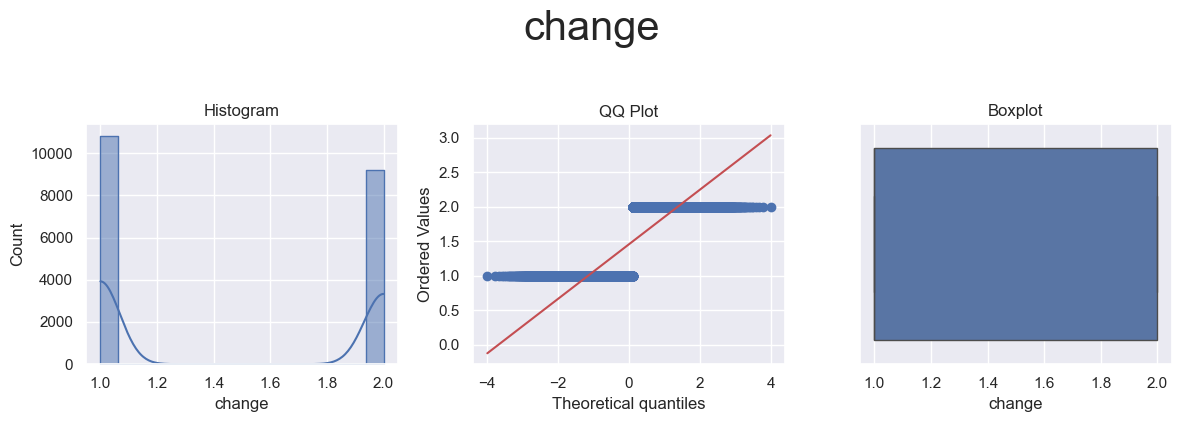

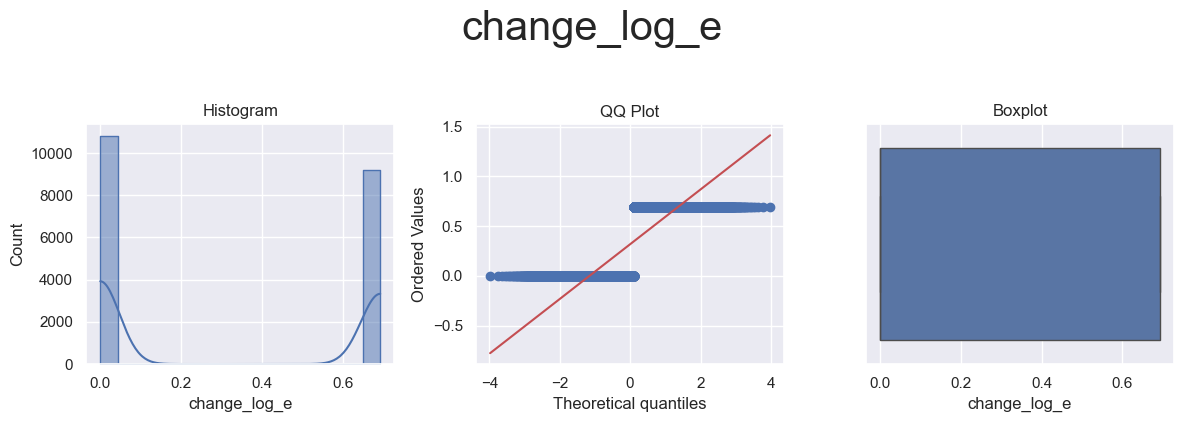

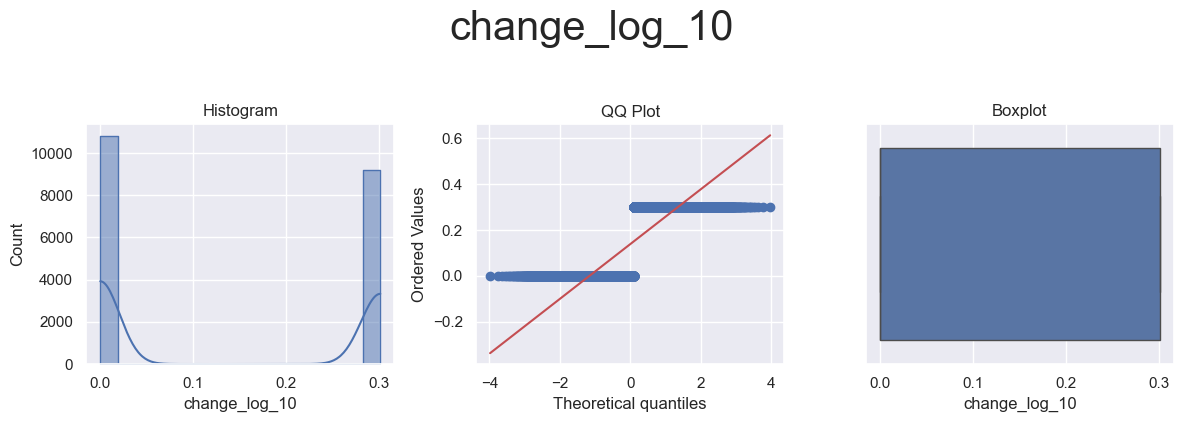

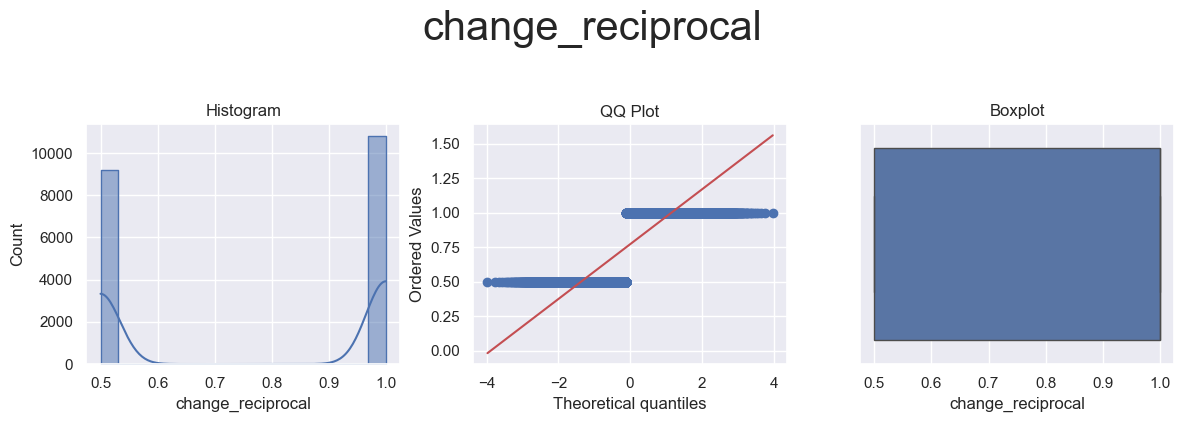

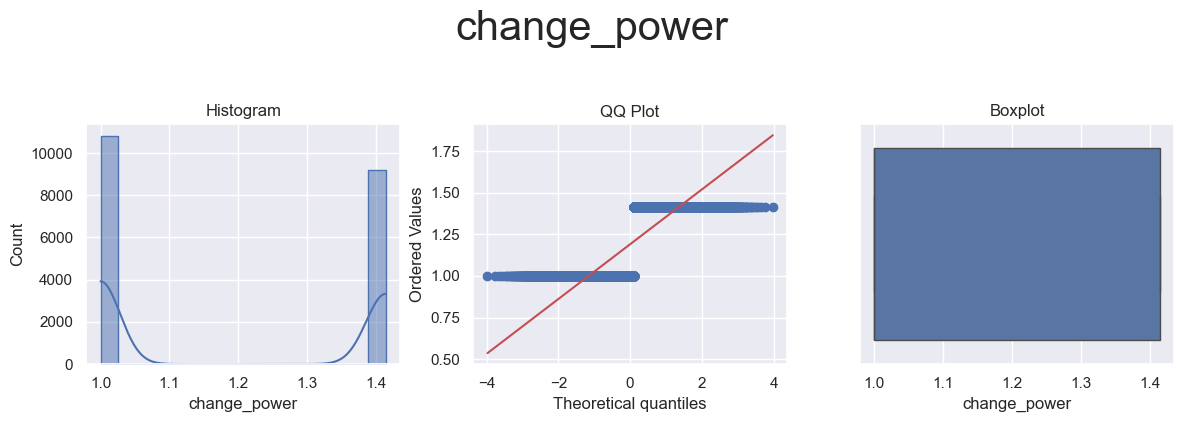

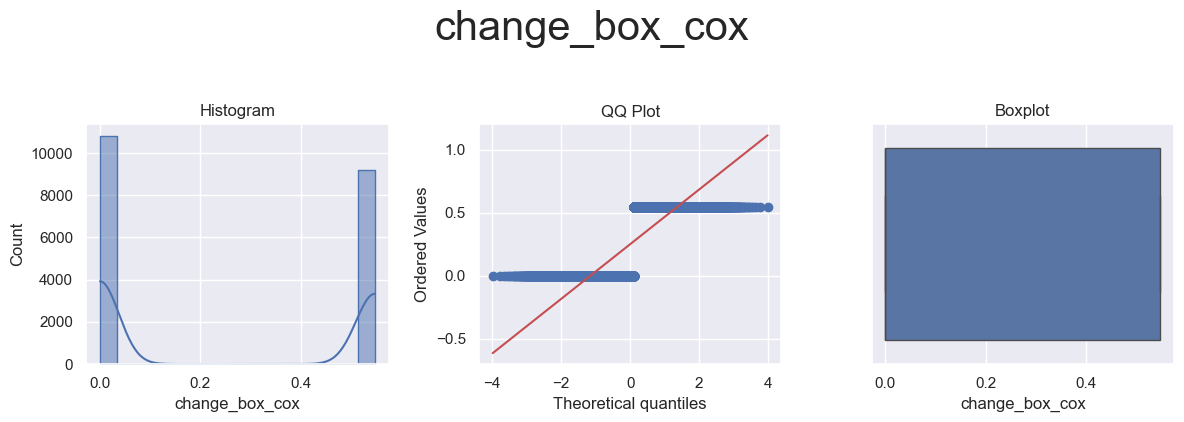

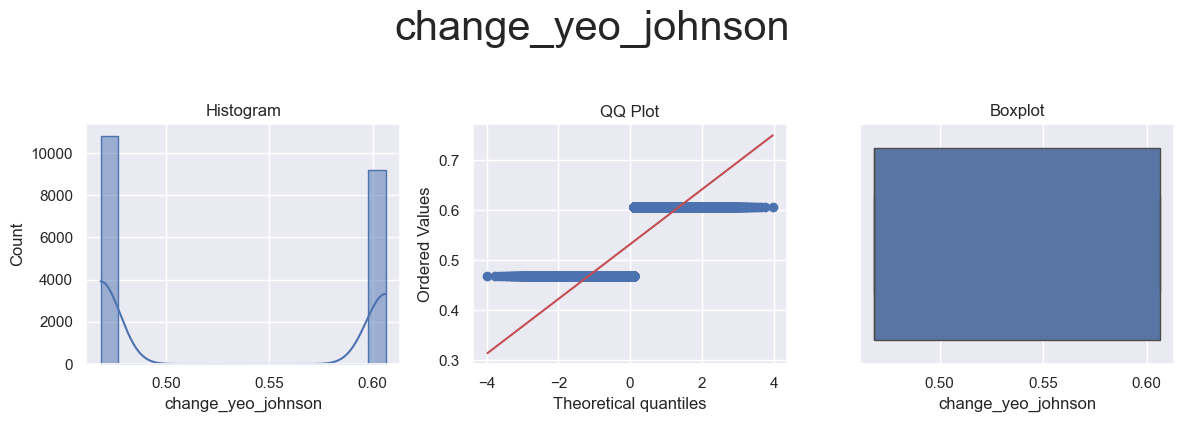



* Variable Analyzed: diabetes_med
* Applied transformation: ['diabetes_med_log_e', 'diabetes_med_log_10', 'diabetes_med_reciprocal', 'diabetes_med_power', 'diabetes_med_box_cox', 'diabetes_med_yeo_johnson'] 



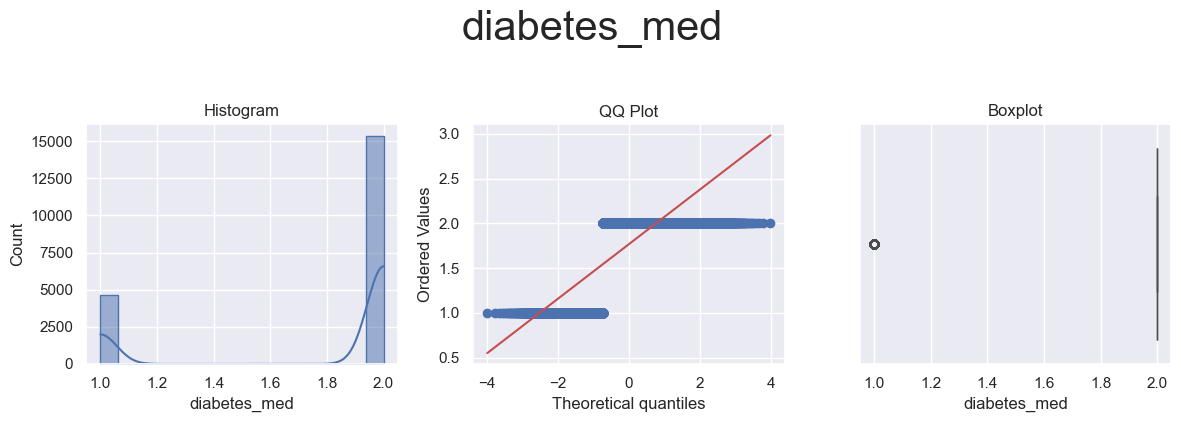

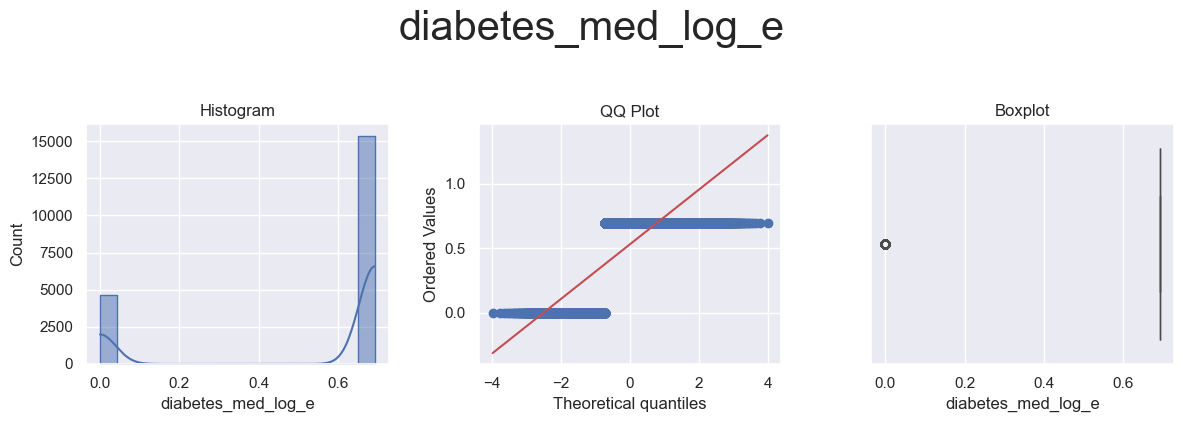

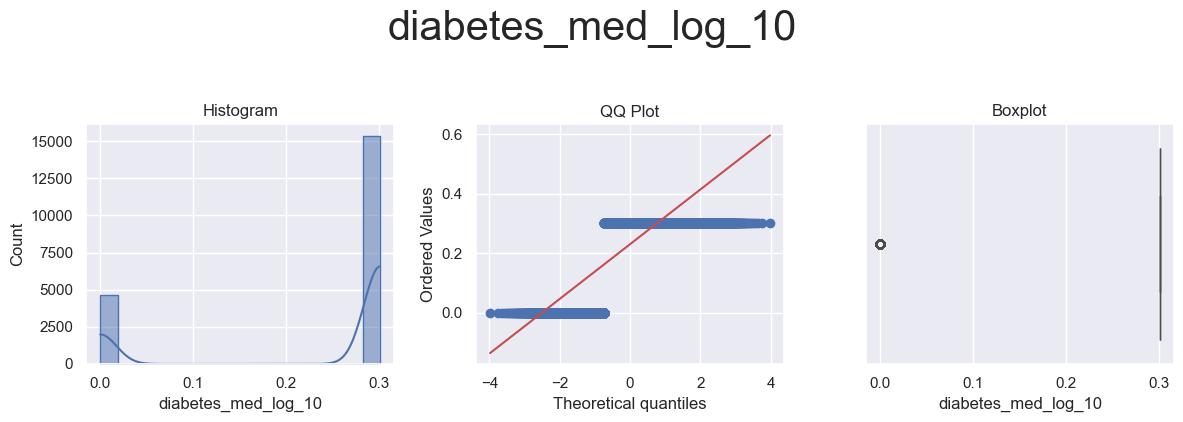

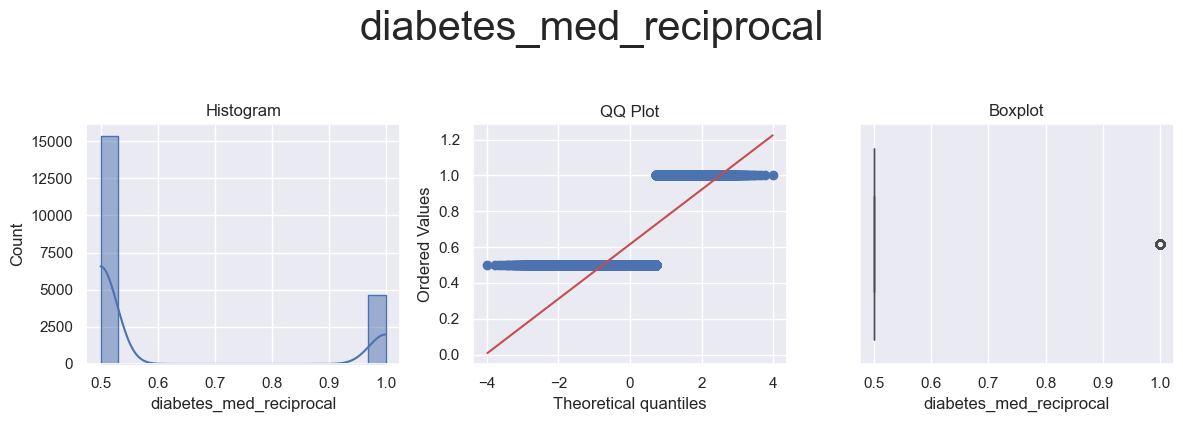

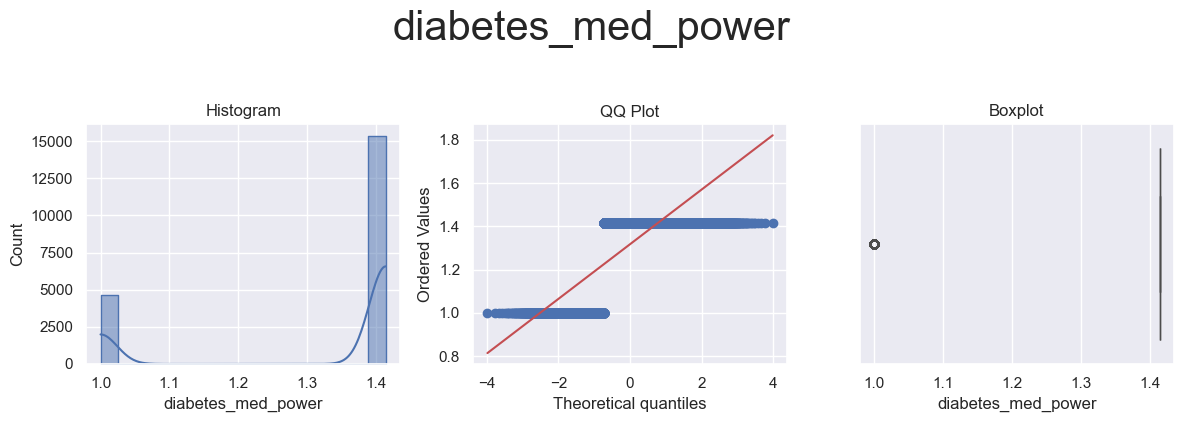

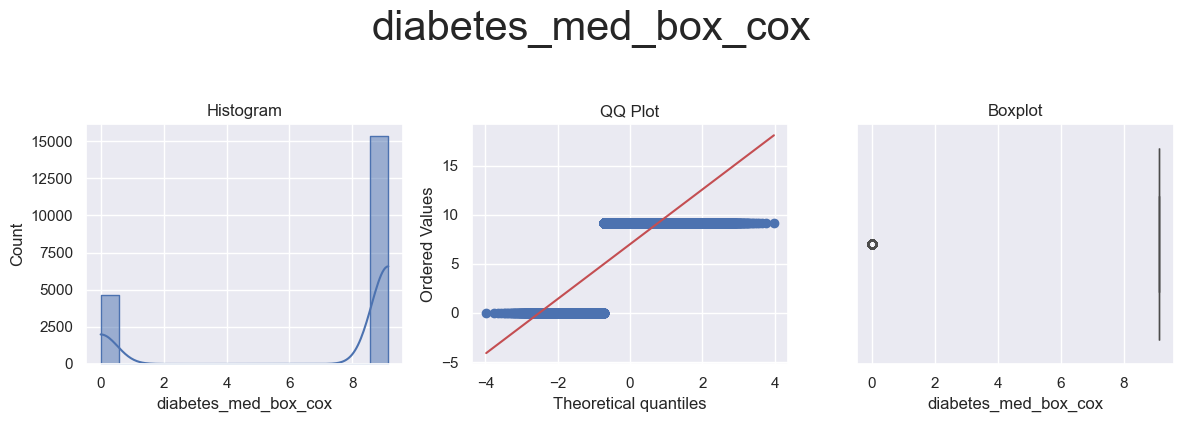

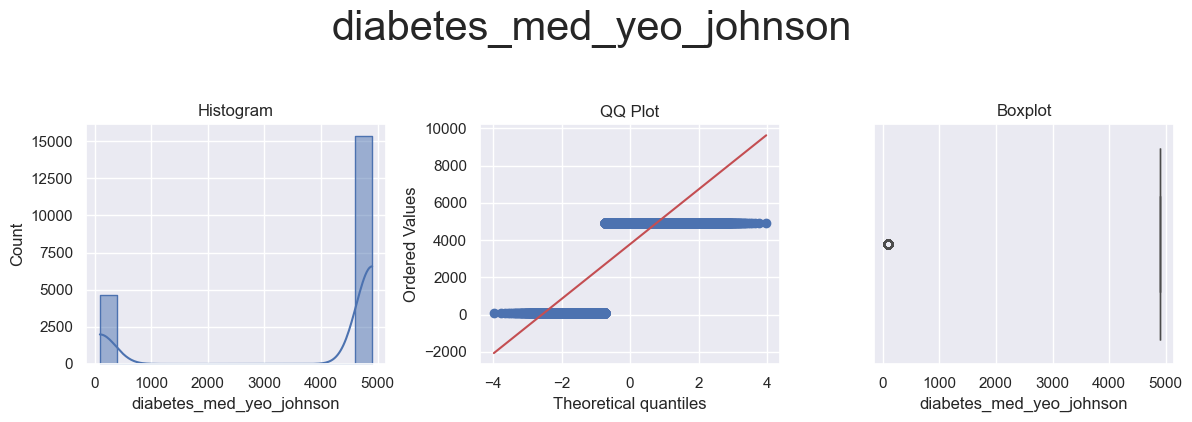

In [14]:
# add a constant to the numerical variables to apply log transformation
df_num_engineering_plus1 = df_num_engineering + 1
df_num_engineered_vt = FeatureEngineeringAnalysis(df_num_engineering_plus1, analysis_type='numerical')

---

## Smart Correlation

In [91]:
df_smart_engineering = TrainSet.copy()
df_smart_engineering.head()

age  time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
0  [70-80)                 4                47             0             21   
1  [60-70)                 3                50             1             11   
2  [50-60)                 4                66             1             10   
3  [50-60)                14                63             0             28   
4  [50-60)                 3                60             2             25   

   n_outpatient  n_inpatient  n_emergency           diag_1       diag_2  \
0             0            1            0            Other        Other   
1             0            0            0  Musculoskeletal  Circulatory   
2             0            0            0            Other        Other   
3             0            0            0      Respiratory  Circulatory   
4             3            2            4            Other     Diabetes   

     diag_3 glucose_test A1Ctest  change  diabetes_med  readmitted  
0     Other           no      no       1             1           1  
1  Diabetes           no      no       0             0           0  
2  Diabetes           no    high       0             0           0  
3  Diabetes       normal      no       0             1           1  
4     Other           no      no       1             1           1

In [92]:
categorical_variables_list = categorical_variables.tolist()
categorical_variables_list

['age', 'diag_1', 'diag_2', 'diag_3', 'glucose_test', 'A1Ctest']

In [93]:
from feature_engine.encoding import OrdinalEncoder

oe = OrdinalEncoder(encoding_method='arbitrary', variables=categorical_variables_list)
df_oe = oe.fit_transform(df_smart_engineering, df_smart_engineering['readmitted'])

df_oe.head()

age  time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
0    0                 4                47             0             21   
1    1                 3                50             1             11   
2    2                 4                66             1             10   
3    2                14                63             0             28   
4    2                 3                60             2             25   

   n_outpatient  n_inpatient  n_emergency  diag_1  diag_2  diag_3  \
0             0            1            0       0       0       0   
1             0            0            0       1       1       1   
2             0            0            0       0       0       1   
3             0            0            0       2       1       1   
4             3            2            4       0       2       0   

   glucose_test  A1Ctest  change  diabetes_med  readmitted  
0             0        0       1             1           1  
1             0        0       0             0           0  
2             0        1       0             0           0  
3             1        0       0             1           1  
4             0        0       1             1           1

In [94]:
from feature_engine.selection import SmartCorrelatedSelection

def correlation_selector(df, method, threshold):
    
    corr_sel = SmartCorrelatedSelection(variables=None, method=method, threshold=threshold,
                                        selection_method="variance")

    corr_sel.fit_transform(df)
    corr_features = corr_sel.correlated_feature_sets_
    features_to_drop = corr_sel.features_to_drop_
    
    print(f"Correlated feature sets: {corr_features}")
    print(f"Features to drop: {features_to_drop}") 

In [95]:
correlation_selector(df_oe, method='spearman', threshold=0.3)

Correlated feature sets: [{'time_in_hospital', 'n_lab_procedures'}, {'n_procedures', 'n_medications'}, {'diabetes_med', 'change'}]
Features to drop: ['time_in_hospital', 'n_procedures', 'diabetes_med']


---

## PCA Analysis

In [96]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 16


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                        for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()

In order to see the difference between the original dataset, without applying any feature engineering, and the dataset we used to do our correlation study we plot both.

* The 16 components explain 100.0% of the data 



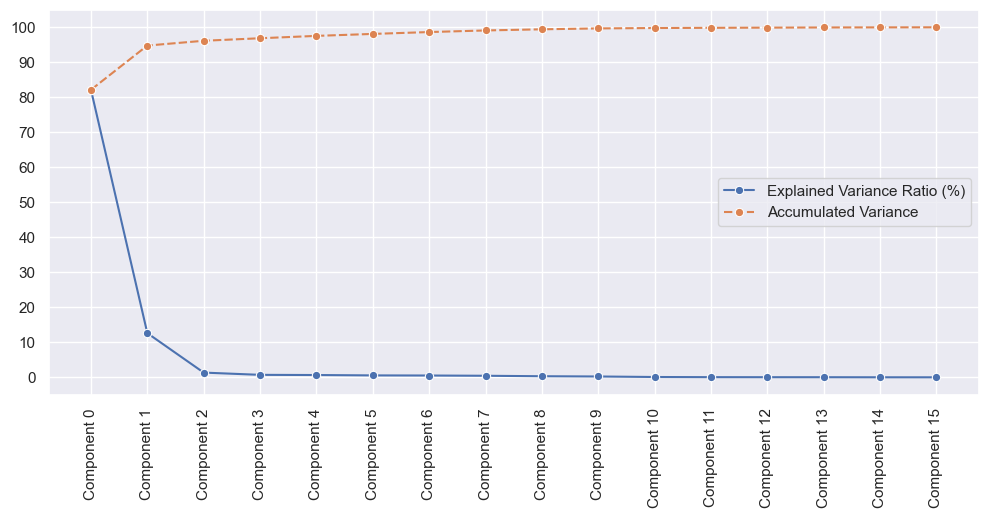

In [97]:
pca_components_analysis(df_pca=df_oe, n_components=n_components)

* The 12 components explain 100.0% of the data 



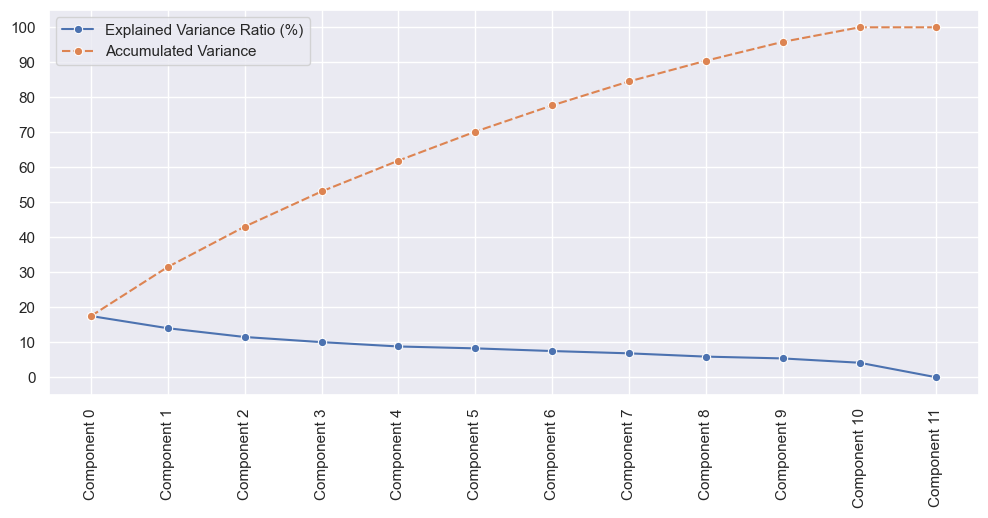

In [98]:
pca_components_analysis(df_pca=df_processed, n_components=12)

From the above we can see the following:

* In the original dataset Component 0 captures a very high amount of variance, close to 80%. Component 1 adds a smaller amount of variance, bringing the cumulative variance up to around 90%. From Component 2 onwards, each additional component captures very little additional variance (close to 0%).

* In the processed dataset Component 0 captures around 20% of the variance, which is moderate but not dominant.
Each subsequent component (Component 1 through Component 10) explains a progressively smaller amount of variance.
Component 10 and Component 11 contribute almost negligible amounts to the variance.
The Accumulated Variance curve rises steadily, indicating that multiple components are needed to explain a significant portion of the variance. 

 If we use PCA, we will consider using the first case, the original dataset, because we can reduce the dimensionality to just 2 or 3 components while still retaining most of the information (variance). This is beneficial because it simplifies the model, reduces computational cost, and helps prevent overfitting.

---

# Conclusions

* Feature Engineering Transformers
  * OrdinalEncoder : `['age', 'diag_1', 'diag_2', 'diag_3', 'glucose_test', 'A1Ctest']`
  * Winsorizer(capping_method='iqr') : `['time_in_hospital', 'n_lab_procedures', 'n_procedures', 'n_medications', 'n_inpatient']`
  * Yeo-Johnson : `['n_medication', 'n_lab_procedures']`
  * Smart Correlation Selection : `['time_in_hospital', 'n_procedures', 'diabetes_med']`

## Next steps

In the next workbook we will move to the Modeling step of the CRISP-DM workflow.